In [1]:
%matplotlib inline

import os 
import sys 
import time
import hashlib

from datetime  import datetime 

import numpy as np  # learn 
import pandas as pd # learn
from pandas import *
from numpy import *

from scipy import stats # look at scipy
from scipy import linalg
from scipy import *
 
import matplotlib as mplt # learn matplolib 
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# import seaborn as sns 
# sns.set_style("whitegrid")
# sns.set(rc={"figure.figsize": (14, 6)})

import IPython
from IPython.display import display


import matplotlib
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
 
# import sklearn as sk
import itertools

# from pyspark import SparkContext, SparkConf
# from pyspark.sql import SQLContext
# from pyspark.sql.types import *
# from pyspark.mllib.regression import LabeledPoint

from keras.models import Sequential 
from keras.layers.core import Dense, Activation, TimeDistributedDense, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import *
# RMSprop, Adadelta
from keras.regularizers import l2, activity_l2

import scipy.stats as st

# http://sebastianruder.com/optimizing-gradient-descent/
# https://leemendelowitz.github.io/blog/how-does-python-find-packages.html

Using Theano backend.


size of noisy data: (14364, 3)
size of noisy data: (14387, 3)
size of noisy data: (14361, 3)
size of noisy data: (14323, 3)
size of noisy data: (14423, 3)
size of noisy data: (13675, 3)
size of noisy data: (9333, 3)


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


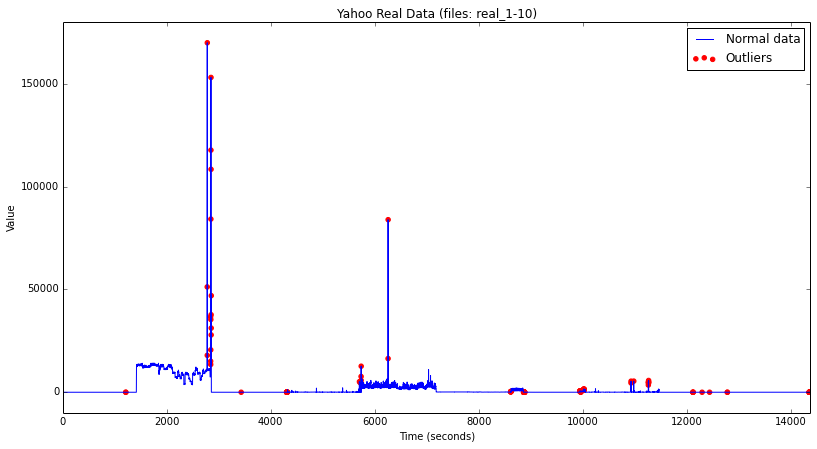

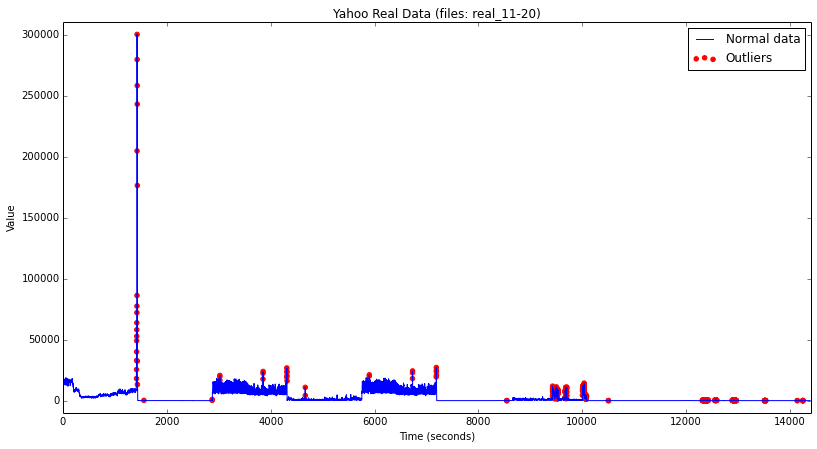

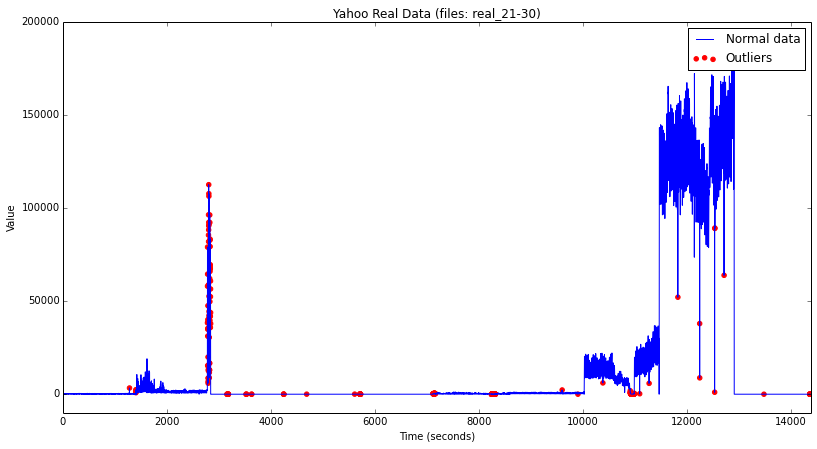

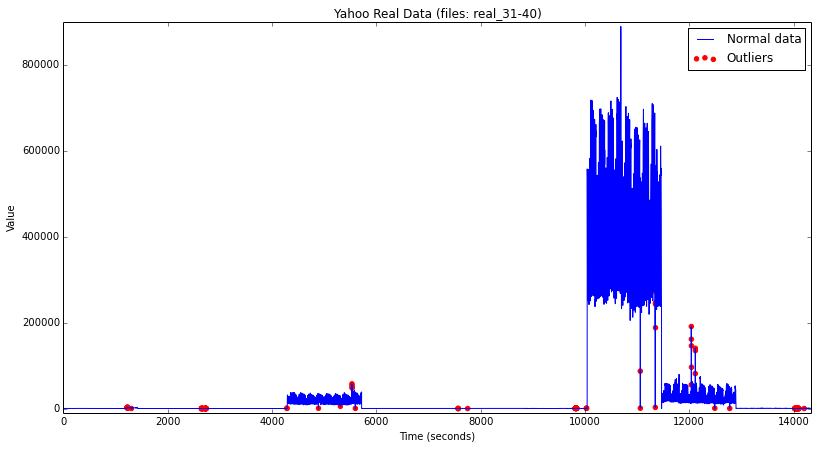

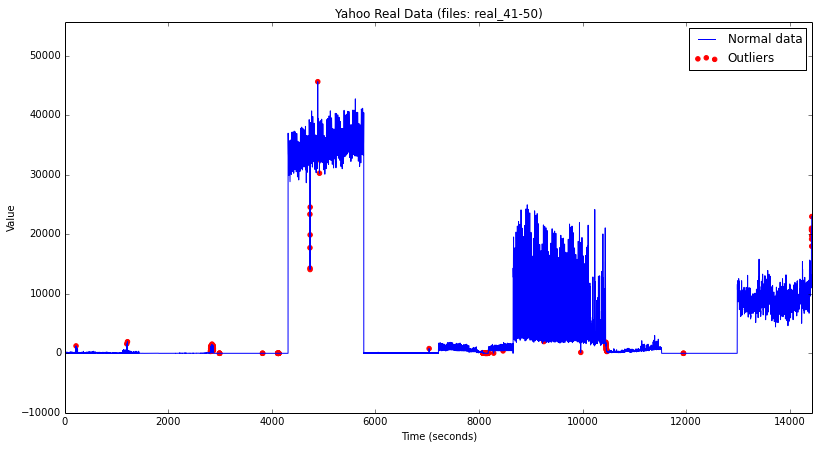

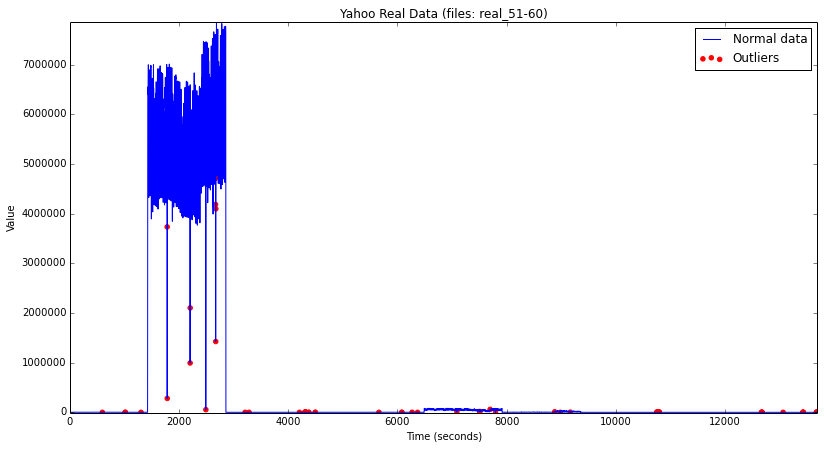

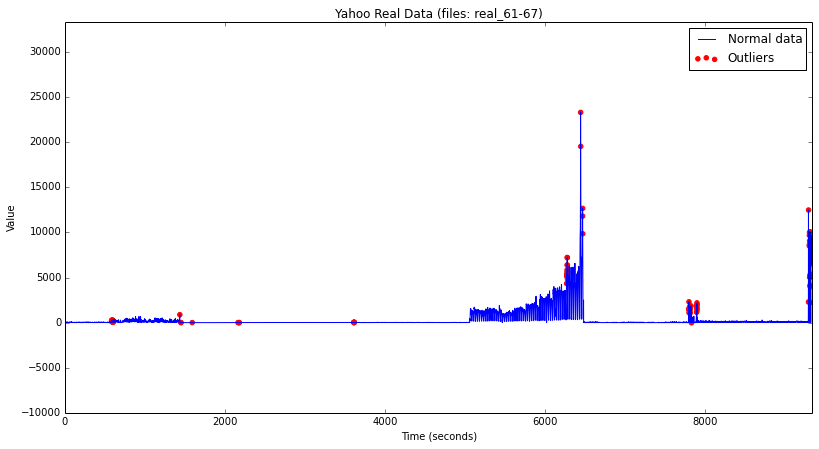

In [2]:
# block1: observe yahoo data to select proper data files for the next experiments 

def load_data_plot(st_file, ed_file):
    
    dta_folder="/home/guo/Downloads/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_"

    curr_cnt=0
    for i in range(st_file, ed_file):
        tmpdf= pd.read_csv( dta_folder + str(i) + ".csv")
        
        if (i-st_file) == 0 :
            tdf= tmpdf
        else:
            tmpdf.drop('timestamp', axis=1, inplace=True)
            tmp_col=  range( curr_cnt+1, curr_cnt + tmpdf.shape[0]+1 ) 
            tmpdf.insert(0, 'timestamp', tmp_col)
            tdf = tdf.append(tmpdf)
        curr_cnt = curr_cnt + tmpdf.shape[0]
    
    print "size of noisy data:", tdf.shape
    
    maxval= max(tdf['value'])
    minval= min(tdf['value'])
    outliers= tdf[ tdf['is_anomaly'] ==1  ]
    
    figure_size= ( 13.4,7)
    legend_font= 8.5
    fig = plt.figure()
    fig.set_size_inches( figure_size )

    plt.plot( list( tdf['value']), label='Normal data' )
    plt.scatter( list(outliers['timestamp']),list(outliers['value']), color='red',\
                label='Outliers'  )

    axes = plt.gca()
    axes.set_xlim([1, tdf.shape[0]+10])
    axes.set_ylim([-10000,maxval+10000])
  
    plt.title('Yahoo Real Data ('+'files: real_'+str(st_file)+'-'+str(ed_file-1)+')')
    plt.ylabel('Value')
    plt.xlabel('Time (seconds)')
    plt.legend()
#     plt.legend(loc=0, ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font , numpoints=1 )
    

for i in range(6):

    file1=i*10+1
    file2=(i+1)*10+1
    
    load_data_plot(file1, file2)
    
load_data_plot(61, 68)


(1439, 3)
(1461, 3)
size of clean data: (2869, 3)
size of noisy data: (2900,) 2900
      timestamp          value  is_anomaly
1360       1361   51251.000000           1
1361       1362   17953.000000           1
1362       1363  170029.000000           1
1426       1427   36705.000000           1
1427       1428   15091.000000           1
1428       1429   13509.000000           1
1429       1430   20628.000000           1
1430       1431   35399.000000           1
1431       1432   84250.000000           1
1432       1433  117800.000000           1
1433       1434  153159.000000           1
1434       1435  108454.000000           1
1435       1436   37714.000000           1
1436       1437   27883.000000           1
1437       1438   31215.000000           1
1438       1439   46988.000000           1
574        2014       5.330278           1
1447       2887       9.110556           1
1448       2888       7.865000           1
1449       2889       8.033333           1
1450       289

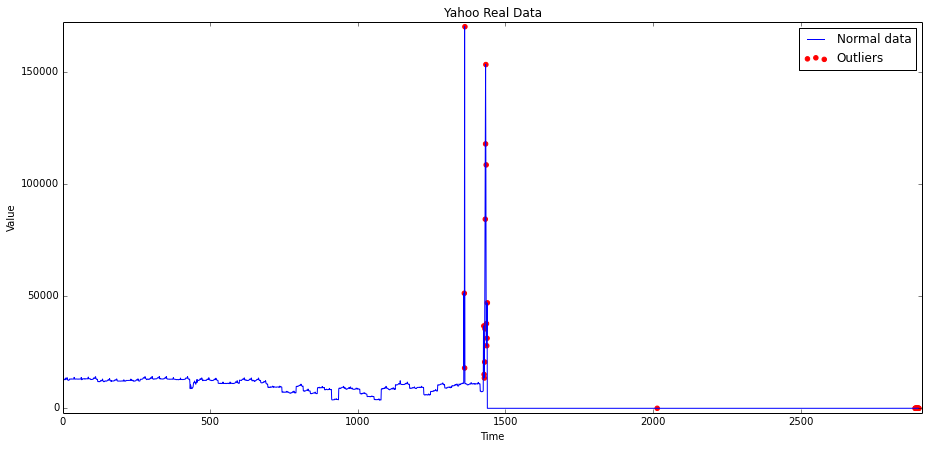

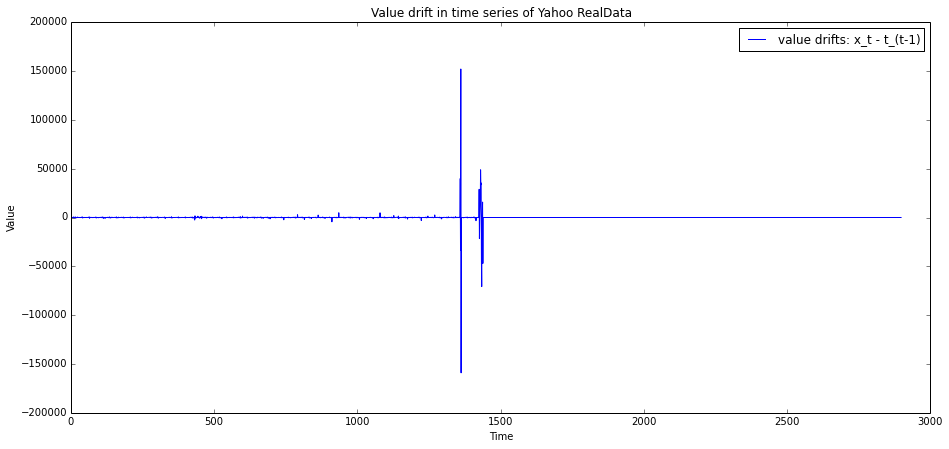

In [47]:
# block2: Training dataset

# load and extract yahoo data
# choose the data in files real_11-20, which contains a time series (data point 3000 - 10000) with mediate 
#  outlier magnitude 

#  this dataset will be used for realtime training RNN 

is_clean=0

curr_cnt=0
st_file=2
ed_file=4

dta_folder="/home/guo/Downloads/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_"
# dta_folder=
# "/home/guo/Downloads/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_"

for i in range(st_file, ed_file):
    tmpdf= pd.read_csv( dta_folder + str(i) + ".csv")
    
#     tmpdf[ 'timestamp' ] = tmpdf[ 'timestamp' ].astype(int64)
#     tmpdf[ 'value' ] = tmpdf[ 'value' ].astype(float64)
#     tmpdf[ 'is_anomaly' ] = tmpdf[ 'is_anomaly' ].astype(int64)
    
    print tmpdf.shape
    
    if (i-st_file) == 0 :
        tdf1= tmpdf
    else:
        tmpdf.drop('timestamp', axis=1, inplace=True)
        tmp_col=  range( curr_cnt+1, curr_cnt + tmpdf.shape[0]+1 ) 
        tmpdf.insert(0, 'timestamp', tmp_col)
        tdf1 = tdf1.append(tmpdf)
    
    curr_cnt = curr_cnt + tmpdf.shape[0]


tdf=tdf1
    
maxval= max(tdf['value'])
minval= min(tdf['value'])

outlier_tdf= tdf[ tdf['is_anomaly'] ==1  ]
clean_tdf =  tdf[ tdf['is_anomaly'] ==0  ]

if is_clean==1:
    ts= clean_tdf['value']
else:
    ts= tdf['value']
    
ts_flag= list(tdf['is_anomaly'])

print "size of clean data:",clean_tdf.shape
print "size of noisy data:", ts.shape, len(ts_flag)

print outlier_tdf
# .............plot.................

figure_size= ( 15.4,7)
legend_font= 8.5
fig = plt.figure()
fig.set_size_inches( figure_size )

axes = plt.gca()
axes.set_xlim([1, tdf.shape[0]+10])
axes.set_ylim([-2000,maxval+2000])

plt.plot( list( tdf['value']), label='Normal data' )
# plt.plot( list( clean_tdf['value']), color='g' )
plt.scatter( list(outlier_tdf['timestamp']),list(outlier_tdf['value']), color='red',\
             label='Outliers')
# plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


# axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
# axes.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Yahoo Real Data')
plt.ylabel('Value')
plt.xlabel('Time')
# plt.legend( loc='upper left',fontsize=12 )
plt.legend()
#     bbox_to_anchor=(0., 1.0, 1., .10),
#            loc=0,
#            ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font , numpoints=1 )




def value_drift_observe( ts ):
    valDrift =  [ ts[i+1]-ts[i] for i in range(len(ts)-1) ]
    
    fig = plt.figure()
    figure_size= ( 15.4,7)
    fig.set_size_inches( figure_size )

    axes = plt.gca()
#     axes.set_xlim([1, tdf.shape[0]+10])
#     axes.set_ylim([-2000,maxval+2000])

    plt.plot( valDrift, label='value drifts: x_t - t_(t-1)' )
# plt.plot( list( clean_tdf['value']), color='g' )
# plt.scatter( list(outlier_tdf['timestamp']),list(outlier_tdf['value']), color='red',\
#              label='Outliers')
# plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


# axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
# axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title('Value drift in time series of Yahoo RealData')
    plt.ylabel('Value')
    plt.xlabel('Time')
# plt.legend( loc='upper left',fontsize=12 )
    plt.legend()
    
    
value_drift_observe( list(tdf['value']) )  


In [4]:
# block3: data pre-processing

# re-organize the data to the format for feeding into the RNN 

import pandas as pd
from random import random
import numpy as np


def extract_load_data( ts_df, st_idx, ed_idx):
    tmpdta = ts_df.iloc[st_idx: ed_idx]
    cnt= len(tmpdta)
    tmpx=[]
    tmpy=[]
    for i in range(cnt-1):
        tmpx.append( tmpdta.iloc[i].as_matrix() )
        tmpy.append( tmpdta.iloc[i+1].as_matrix() )

    return tmpx, tmpy, tmpdta.iloc[cnt-1].as_matrix()

def format_timeseries_rnn(ts):
    tmptrnx =[]
    tmptrny =[]
    
    ts_df= pd.DataFrame(ts)
    
    tmpPre = 0
    tmpCur = len(ts)
    
    tmpx,tmpy, tmpy1 = extract_load_data( ts_df, tmpPre,tmpCur)
    tmptrnx.append(tmpx)
    tmptrny.append(tmpy)
    
    # qualified format for rnn
    dtax = np.array( tmptrnx )
    dtay = np.array( tmptrny )

#     print dtax.shape, dtay.shape
    return dtax, dtay



In [39]:
# block4:  RNN configureation

hidden_neurons = 450

# learning rate
lr_val = 0.001

# all the available optimizers
sgd = SGD(lr= lr_val, momentum=0.03, decay=0.0, nesterov=True)
rms = RMSprop(lr= lr_val, rho=0.9, epsilon=1e-06)

#Keras says: it is recommended to leave the parameters of this optimizer 
# at their default values for the two optimizers below
adagrad = Adagrad(lr=0.01, epsilon=1e-06)
adadelta = Adadelta(lr=1.0,rho=0.95,epsilon=1e-06)

adam =  Adam(lr= lr_val, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
adamax = Adamax(lr= lr_val, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

opt_list=[ sgd, rms, adagrad, adadelta, adam, adamax ]
opt_namelist=[ "SGD with Momentum","RMSprop","ADAGRAD","ADADELTA","ADAM","ADAMAX" ]


loss_func = "mean_squared_error"

In [43]:
def robust_rl_train_rnn(dtax, dtay, optimizer_config, loss_func, outlier_flag, regular_para):
    
    timesteps =1 
    in_out_neurons = 1
    
    test_step=2
    
    trn_size= dtax.shape[1]-3
    trnx = dtax 
    trny = dtay 
    
    testx=[]
    testy=[]
    testyh=[]

    rl_model = Sequential()
    rl_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
                  batch_input_shape = (1,timesteps, in_out_neurons ) ,\
                      W_regularizer=l2( regular_para ) ))
    rl_model.add(TimeDistributedDense(output_dim= in_out_neurons ) )
    rl_model.add(Activation("linear")) 

    rl_model.compile(loss= loss_func, optimizer= optimizer_config )
    
    resi_mean= 0.0
    resi_sqr = 0.0
    resi_var= 0.0 
    
    pre_resi_mean= 0.0
    pre_resi_sqr = 0.0
    pre_resi_var= 0.0 
    
    seg_cnt=0

    ma_vshift=0.0
    ma_coef=0.7
    vshift_bound = 2
    
    mker_vshift = 0.0
    
    pre_pro=0.0
    
    
    for i in range(trn_size):
        cur_trnx= trnx[:,i:i+1,:] 
        cur_trny= trny[:,i:i+1,:]
        
        tmp_trnx= cur_trnx[0][0][0]
        tmp_trny= cur_trny[0][0][0]

        if seg_cnt >= 1:
            
            if pre_pro>0.995 or pre_pro<0.005:

                cur_trnx[0][0][0] = cur_trnx[0][0][0] - ma_vshift
                
                cur_pred = rl_model.predict_on_batch( cur_trnx )[0][0][0]
                tmpresi = cur_trny[0][0][0] - cur_pred[0]
                
                tmp_zval = (tmpresi-resi_mean )*1.0 / sqrt(resi_var)
                tmp_pro =  st.norm.cdf( tmp_zval)
#                 print "at time step:",i,":", tmp_pro, ma_vshift,cur_trnx[0][0][0],\
#                 cur_trny[0][0][0],ts_flag[i]
#                 pre_pro =0.5  
                
    
                if not (tmp_pro>0.995 or tmp_pro<0.005):
                    pre_pro =0.5 
#                     cur_trny[0][0][0] = cur_trnx[0][0][0] + ma_vshift
                else:
                    
                    tmp_vshift = trny[:,i:i+1,:][0][0][0]-trnx[:,i:i+1,:][0][0][0]
                    
                    if tmp_vshift >= vshift_bound*mker_vshift:
                        cur_trny[0][0][0] = cur_trnx[0][0][0] + mker_vshift
#                         continue
                    else:
                        cur_trny[0][0][0] = cur_trnx[0][0][0] + ma_vshift
                        
                    pre_pro = tmp_pro
   
        
            else:
                
                cur_pred = rl_model.predict_on_batch( cur_trnx )[0][0][0]
                tmpresi = cur_trny[0][0][0] - cur_pred[0]
                
                tmp_zval = (tmpresi-resi_mean )*1.0 / sqrt(resi_var)
                tmp_pro =  st.norm.cdf( tmp_zval)
#                 print "at time step:",i,":", tmp_pro, ma_vshift,cur_trnx[0][0][0],\
#                 cur_trny[0][0][0],ts_flag[i]
                
                if tmp_pro>0.995 or tmp_pro<0.05:
                    cur_trny[0][0][0] = cur_trnx[0][0][0] + ma_vshift
                    mker_vshift = ma_vshift

                
                pre_pro= tmp_pro

            
        rl_model.train_on_batch(cur_trnx,cur_trny) 
        
        
        if i%test_step ==0 and ts_flag[i+2]!=1 and ts_flag[i+1]!=1 :
            vali_testx=  trnx[:, i+1:i+2,:]
            pred_test = rl_model.predict_on_batch( vali_testx )[0][0][0]
#             print "at time step:",i,":", pred_test, "--v.s.--",trnx[:, i+2:i+3,:][0][0]
        
            testx.append( vali_testx[0][0] )
            testy.append( trny[:, i+1:i+2,:][0][0])
            testyh.append( pred_test   )
            
#         if i == trn_size-3 and ts_flag[i+2]!=1 and ts_flag[i+1]!=1 :
#             vali_testx=  trnx[:, i+1:i+2,:]
#             pred_test = rl_model.predict_on_batch( vali_testx )[0][0][0]
# #             print "at time step:",i,":", pred_test, "--v.s.--", trnx[:, i+2:i+3,:][0][0]
        
#             testx.append( vali_testx[0][0] )
#             testy.append( trny[:, i+1:i+2,:][0][0])
#             testyh.append( pred_test   )
        
        
        pre_resi_mean= resi_mean
        pre_resi_sqr = resi_sqr
        pre_resi_var=  resi_var
        
        
        cur_pred = rl_model.predict_on_batch( cur_trnx )[0][0][0]
        tmpresi = cur_trny[0][0][0] - cur_pred[0]
        
        resi_mean= ( resi_mean * seg_cnt*1.0 + tmpresi)/(seg_cnt+1)
        resi_sqr = resi_sqr + tmpresi*tmpresi
        resi_var= resi_sqr/(seg_cnt+1) - resi_mean* resi_mean
        seg_cnt = seg_cnt+1
        
        if abs(resi_mean-pre_resi_mean) >= abs(pre_resi_mean)*0.1:
            resi_mean= tmpresi
            resi_sqr = tmpresi*tmpresi
            seg_cnt = 1
            resi_var= resi_var*0.8
#             resi_sqr/(seg_cnt) - resi_mean* resi_mean
            
        
        ma_vshift = (1.0-ma_coef)*ma_vshift + ma_coef*\
        (trny[:,i:i+1,:][0][0][0]-trnx[:,i:i+1,:][0][0][0])
        
        
    return testx, testy, testyh

Normalzied MSE using SGD with Momentum on NOISY data:  2099.40777841


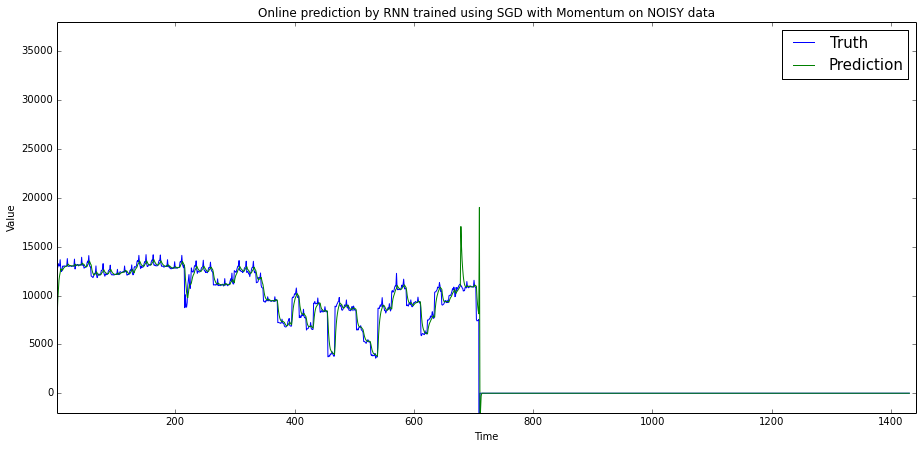

In [44]:
# single run

dtax, dtay = format_timeseries_rnn( tdf['value'] )

# len(opt_list)
# for i in range(len(opt_list)):
tst_x, tst_y, tst_pred_y = robust_rl_train_rnn(dtax, dtay, opt_list[0], loss_func,\
                                               ts_flag,0.0001)
test_result_plot(tst_x, tst_y, tst_pred_y, opt_namelist[0], "NOISY data")

Normalzied MSE using SGD with Momentum on NOISY data:  925.10305149
Numerical errors on SGD:
Normalzied MSE on Learning rate 0.0001: 1652.80924499
Normalzied MSE on Learning rate 0.001: 762.937622648
Normalzied MSE on Learning rate 0.01: nan
Numerical errors on SGD:
Normalzied MSE on Learning rate 0.0001: 1550.50685028
Normalzied MSE on Learning rate 0.001: 579.793907482
Normalzied MSE on Learning rate 0.01: nan


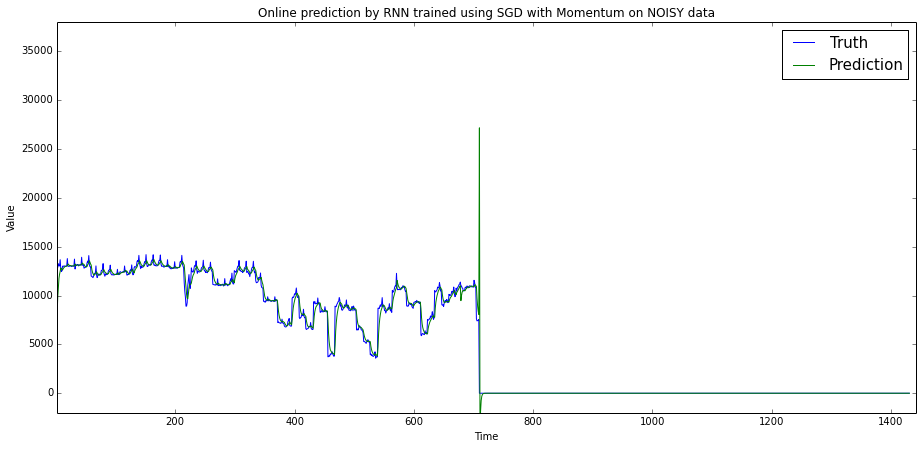

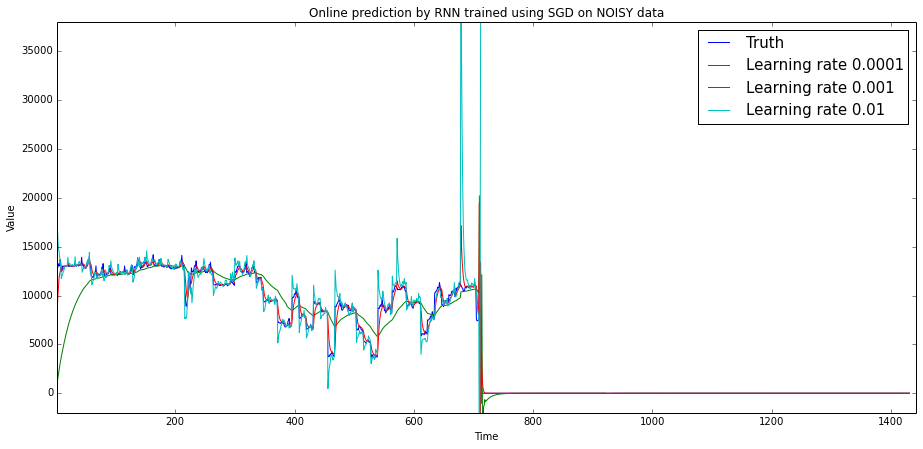

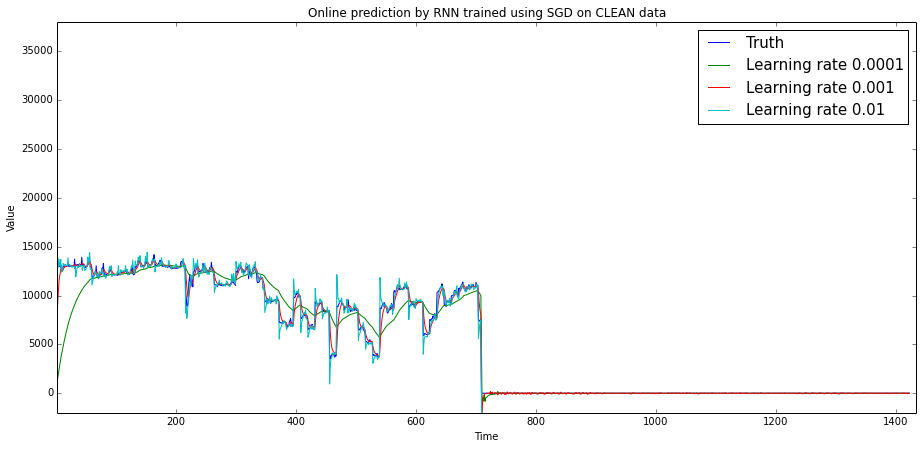

In [17]:
dtax, dtay = format_timeseries_rnn( tdf['value'] )

# len(opt_list)
# for i in range(len(opt_list)):
tst_x, tst_y, tst_pred_y = robust_rl_train_rnn(dtax, dtay, opt_list[0], loss_func,\
                                               ts_flag,0.0001)
test_result_plot(tst_x, tst_y, tst_pred_y, opt_namelist[0], "NOISY data")
    
    
    
lr_vals=[0.00001,0.00005,  0.0001, 0.0005, 0.001, 0.005 ]
pred_y_lr=[]
for tmp_lr in lr_vals:
    sgd = SGD(lr= tmp_lr, momentum=0.03, decay=0.0, nesterov=True)
    
#     tst_x, tst_y, tst_pred_y = robust_rl_train_rnn(dtax, dtay, opt_list[0], loss_func,\
#                                                ts_flag,0.0001)
#     test_result_plot(tst_x, tst_y, tst_pred_y, opt_namelist[0], "NOISY data")
    
    tst_x, tst_y, tst_pred_y = robust_rl_train_rnn(dtax, dtay, sgd, loss_func,ts_flag,0.0001)
    pred_y_lr.append(tst_pred_y)
# prediction_learningRate_plot( tst_y, pred_y_lr, 'SGD' )
prediction_para_plot( tst_y , pred_y_lr , 'SGD' , "Learning rate " , lr_vals, 'NOISY data' )




dtax, dtay = format_timeseries_rnn(  clean_tdf['value'])
loss_func = "mean_squared_error"
allzero_ts_flag = [0]*len(dtax[0])

pred_y_lr=[]
for tmp_lr in lr_vals:
    sgd = SGD(lr= tmp_lr, momentum=0.03, decay=0.0, nesterov=True)
    
#     tst_x, tst_y, tst_pred_y = robust_rl_train_rnn(dtax, dtay, opt_list[0], loss_func,\
#                                                ts_flag,0.0001)
#     test_result_plot(tst_x, tst_y, tst_pred_y, opt_namelist[0], "NOISY data")
    
    tst_x, tst_y, tst_pred_y = robust_rl_train_rnn(dtax, dtay, sgd, loss_func,ts_flag,0.0001)
    pred_y_lr.append(tst_pred_y)
# prediction_learningRate_plot( tst_y, pred_y_lr, 'SGD' )
prediction_para_plot( tst_y , pred_y_lr , 'SGD' , "Learning rate " , lr_vals,'CLEAN data' )

In [14]:
cnt=0
dtax, dtay = format_timeseries_rnn( tdf['value'] )

# print len(dtax)
for i in range(len(ts_flag)-1):
    if ts_flag[i]==1:
        cnt= cnt+1
        print i, dtax[:,i-1], dtay[:,i-1], dtax[:,i], dtay[:,i]
print cnt
# ts_flag

 1360 [[ 11367.]] [[ 51251.]] [[ 51251.]] [[ 17953.]]
1361 [[ 51251.]] [[ 17953.]] [[ 17953.]] [[ 170029.]]
1362 [[ 17953.]] [[ 170029.]] [[ 170029.]] [[ 10955.]]
1426 [[ 7848.]] [[ 36705.]] [[ 36705.]] [[ 15091.]]
1427 [[ 36705.]] [[ 15091.]] [[ 15091.]] [[ 13509.]]
1428 [[ 15091.]] [[ 13509.]] [[ 13509.]] [[ 20628.]]
1429 [[ 13509.]] [[ 20628.]] [[ 20628.]] [[ 35399.]]
1430 [[ 20628.]] [[ 35399.]] [[ 35399.]] [[ 84250.]]
1431 [[ 35399.]] [[ 84250.]] [[ 84250.]] [[ 117800.]]
1432 [[ 84250.]] [[ 117800.]] [[ 117800.]] [[ 153159.]]
1433 [[ 117800.]] [[ 153159.]] [[ 153159.]] [[ 108454.]]
1434 [[ 153159.]] [[ 108454.]] [[ 108454.]] [[ 37714.]]
1435 [[ 108454.]] [[ 37714.]] [[ 37714.]] [[ 27883.]]
1436 [[ 37714.]] [[ 27883.]] [[ 27883.]] [[ 31215.]]
1437 [[ 27883.]] [[ 31215.]] [[ 31215.]] [[ 46988.]]
1438 [[ 31215.]] [[ 46988.]] [[ 46988.]] [[ 3.71666667]]
2013 [[ 3.54194444]] [[ 5.33027778]] [[ 5.33027778]] [[ 3.77277778]]
2886 [[ 3.24055556]] [[ 9.11055556]] [[ 9.11055556]] [[ 7.865]]


In [12]:
#block5: define a function for training RNN

# continusly feed the data into RNN to update the model
def rl_train_rnn(dtax, dtay, optimizer_config, loss_func, outlier_flag, regular_para):
    
    timesteps =1 
    in_out_neurons = 1
    test_step=2
    
    trn_size= dtax.shape[1]-3
    trnx = dtax 
    trny = dtay 
    
    testx=[]
    testy=[]
    testyh=[]

#     print trnx.shape, trny.shape

    rl_model = Sequential()
    rl_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
                  batch_input_shape = (1,timesteps, in_out_neurons ) ,\
                      W_regularizer=l2( regular_para ) ))
    rl_model.add(TimeDistributedDense(output_dim= in_out_neurons ) )
    rl_model.add(Activation("linear")) 

    rl_model.compile(loss= loss_func, optimizer= optimizer_config )
#                  "r11460msprop")

    for i in range(trn_size):
        cur_trnx= trnx[:,i:i+1,:] 
        cur_trny= trny[:,i:i+1,:]
    
#     print 'data instance:', i, 'of size:', cur_trnx.shape, cur_trny.shape

        rl_model.train_on_batch(cur_trnx,cur_trny) 
    
        
        if i%test_step ==0 and ts_flag[i+2]!=1 and ts_flag[i+1]!=1 :
            vali_testx=  trnx[:, i+1:i+2,:]
            pred_test = rl_model.predict_on_batch( vali_testx )[0][0][0]
#             print "at time step:",i,":", pred_test, "--v.s.--",trnx[:, i+2:i+3,:][0][0]
        
            testx.append( vali_testx[0][0] )
            testy.append( trny[:, i+1:i+2,:][0][0])
#             testy.append( trnx[:, i+2:i+3,:][0][0])
            testyh.append( pred_test   )
            
        if i == trn_size-3 and ts_flag[i+2]!=1 and ts_flag[i+1]!=1 :
            vali_testx=  trnx[:, i+1:i+2,:]
            pred_test = rl_model.predict_on_batch( vali_testx )[0][0][0]
#             print "at time step:",i,":", pred_test, "--v.s.--", trnx[:, i+2:i+3,:][0][0]
        
            testx.append( vali_testx[0][0] )
            testy.append( trny[:, i+1:i+2,:][0][0])
            testyh.append( pred_test   )
    
    return testx, testy, testyh
    
def test_result_plot(testx, testy, testyh, method_name, isNoise):
    
    fig = plt.figure()
    figure_size= ( 15.4,7)
    fig.set_size_inches( figure_size )
    
    plt.title('Online prediction by RNN trained using '+ method_name + ' on '+isNoise )
    plt.ylabel('Value')
    plt.xlabel('Time')

    plt.plot(testy, label='Truth')
    plt.plot(testyh, label='Prediction')
#     plt.scatter( list(outlier_tdf['timestamp']),list(outlier_tdf['value']), color='red',\
#              label='Outliers')
    
    plt.legend( loc='upper right',fontsize=15 )

    axes = plt.gca()
    axes.set_xlim([1, len(testx)+10])
    axes.set_ylim([-2000,38000])

    cnt= len(testy)

    nmse = sqrt(sum([(testy[i]- testyh[i])*(testy[i]- testyh[i]) for i in range(cnt)])*1.0/cnt)
    print 'Normalzied MSE using '+ method_name + ' on '+ isNoise + ': ', nmse


Normalzied MSE using SGD with Momentum on NOISY data:  1116.20377562
Normalzied MSE using RMSprop on NOISY data:  6177.19936821
Normalzied MSE using ADAGRAD on NOISY data:  6186.70332095
Normalzied MSE using ADADELTA on NOISY data:  5950.768381
Normalzied MSE using ADAM on NOISY data:  6187.95898618
Normalzied MSE using ADAMAX on NOISY data:  6180.38005614


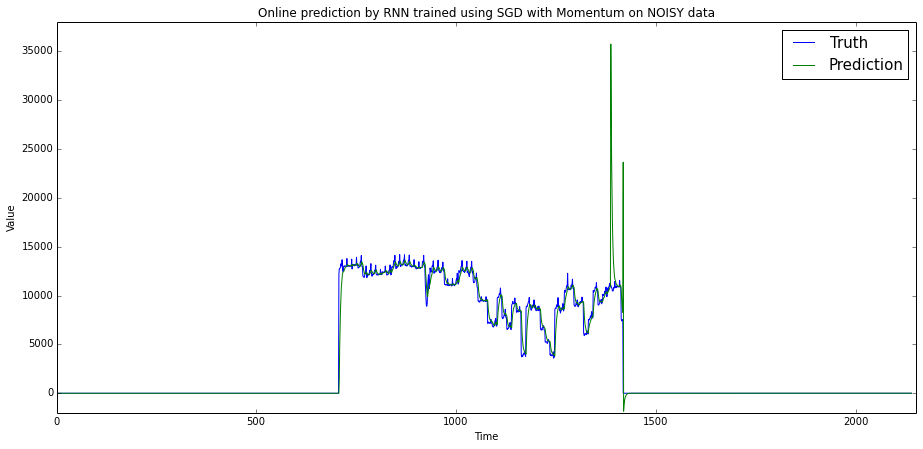

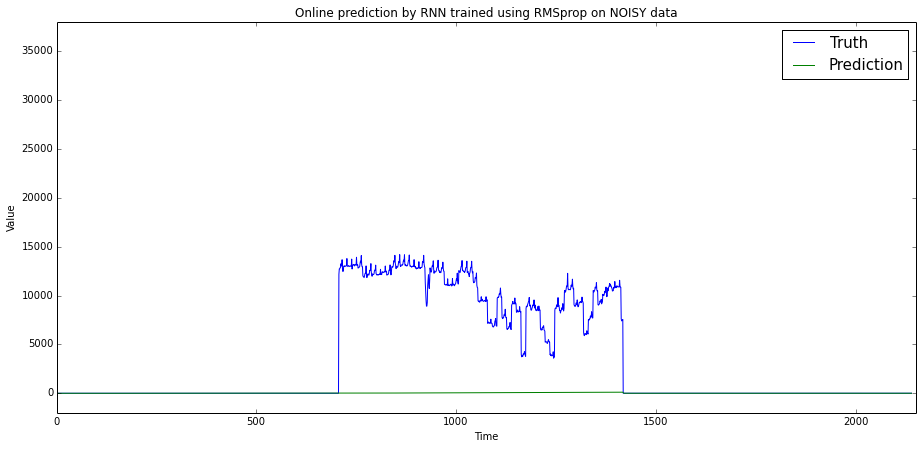

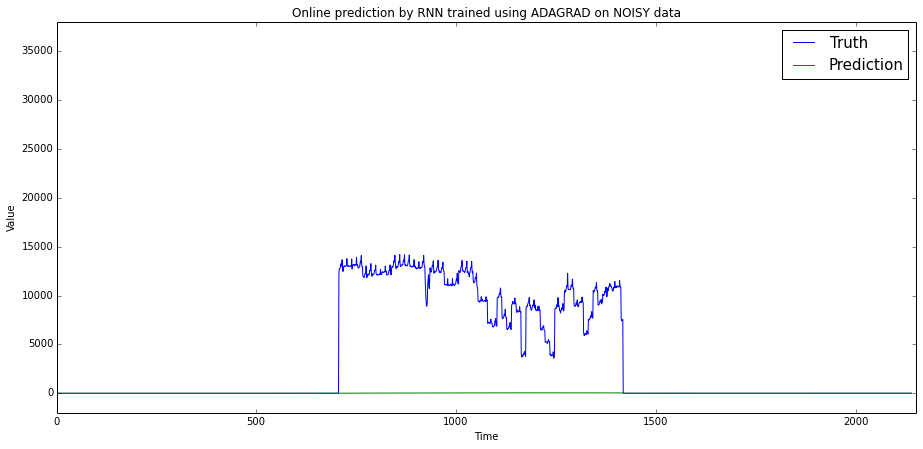

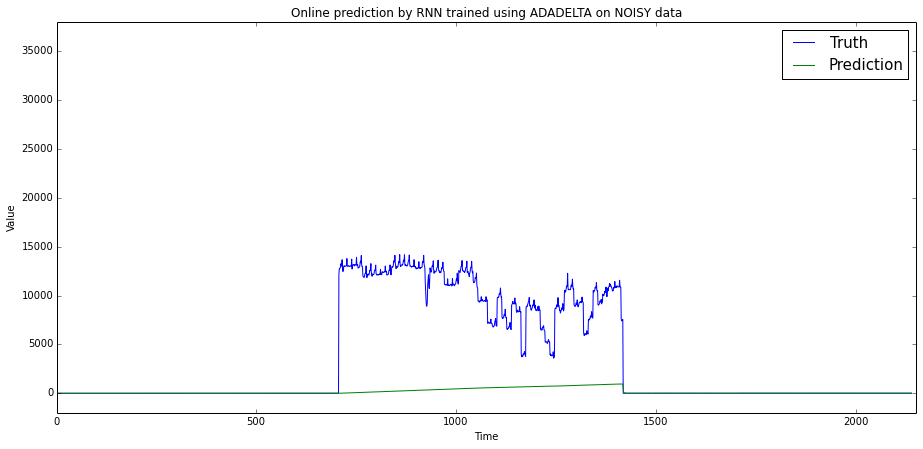

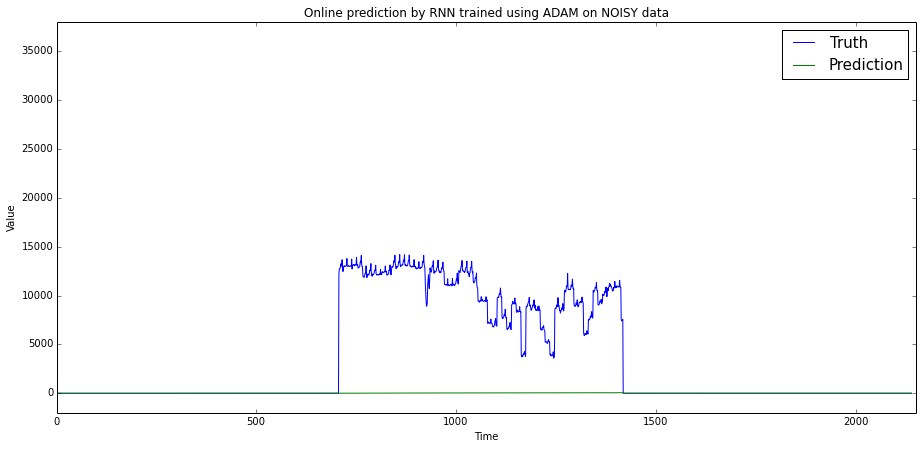

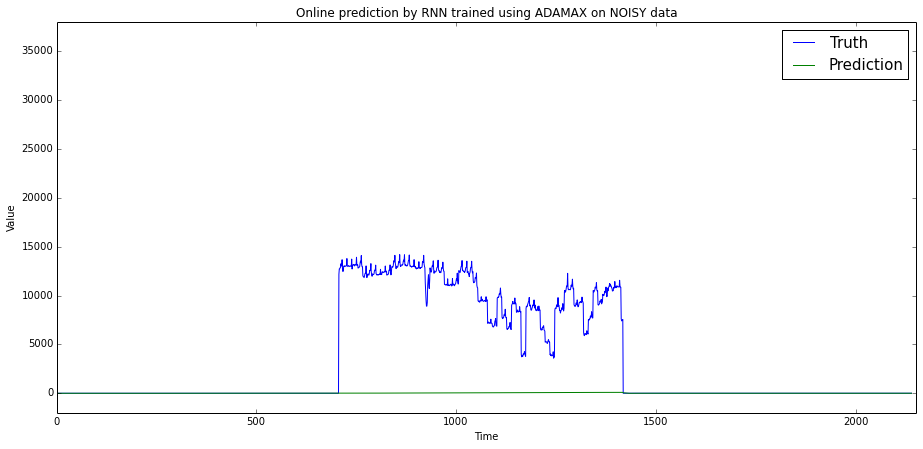

In [110]:
# block 6: real-time train RNN on NOISE data 
# by different optimzers and plot the prediction results

dtax, dtay = format_timeseries_rnn( tdf['value'] )
loss_func = "mean_squared_error"

# len(opt_list)
for i in range(len(opt_list)):
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, opt_list[i], loss_func, ts_flag)
    test_result_plot(tst_x, tst_y, tst_pred_y, opt_namelist[i], "NOISY data")
    
    

(1, 2868, 1) (1, 2868, 1)
(1, 2868, 1) (1, 2868, 1)
Normalzied MSE: 706.198218555
(1, 2868, 1) (1, 2868, 1)
Normalzied MSE: 7543.97790685
(1, 2868, 1) (1, 2868, 1)
Normalzied MSE: 7553.21084515
(1, 2868, 1) (1, 2868, 1)
Normalzied MSE: 7395.53797214
(1, 2868, 1) (1, 2868, 1)
Normalzied MSE: 7497.11991077
(1, 2868, 1) (1, 2868, 1)
Normalzied MSE: 7546.42912532


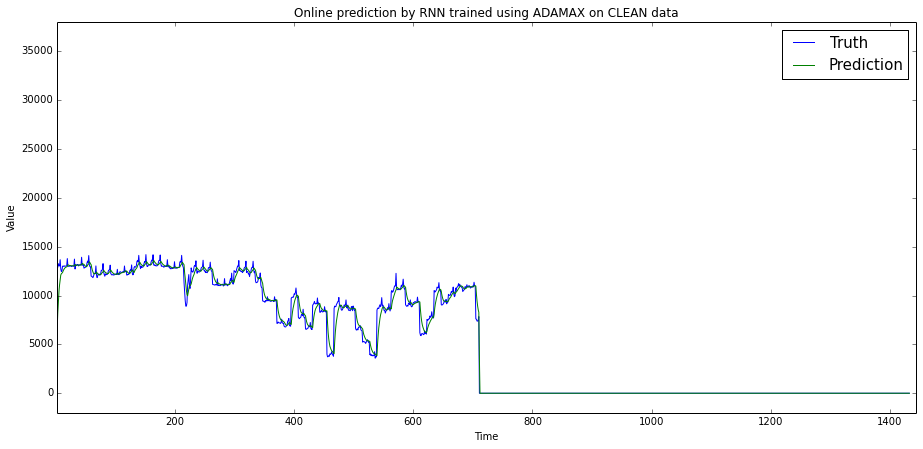

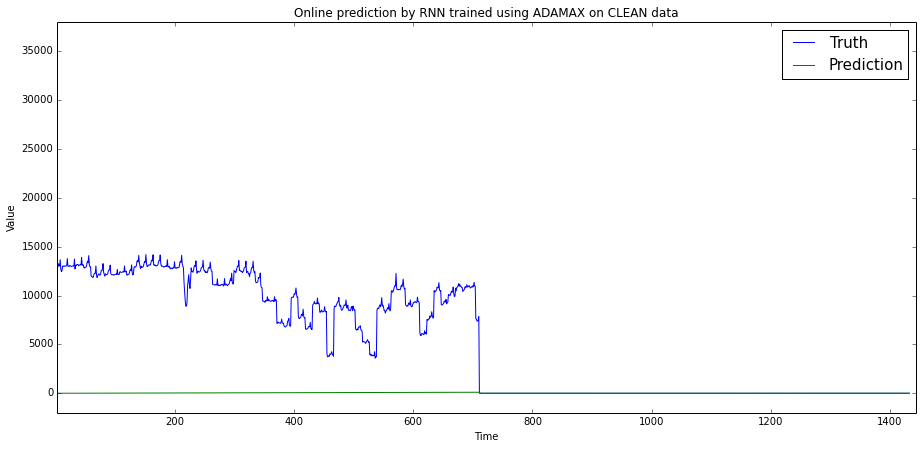

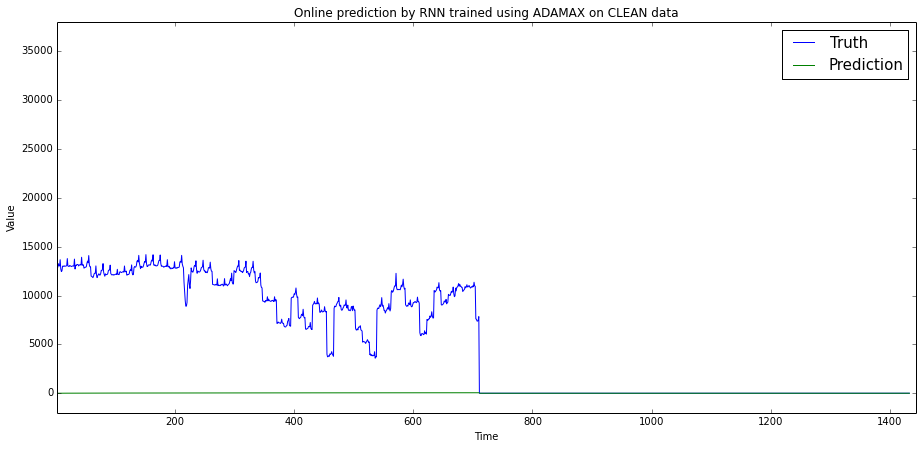

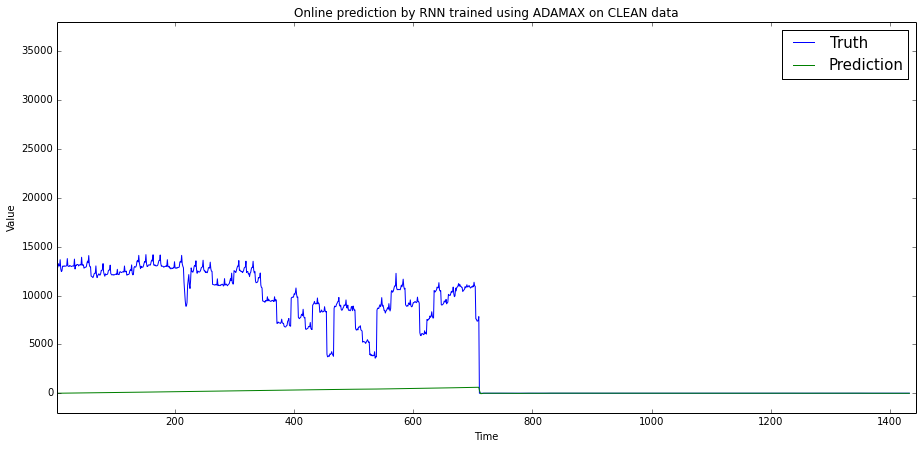

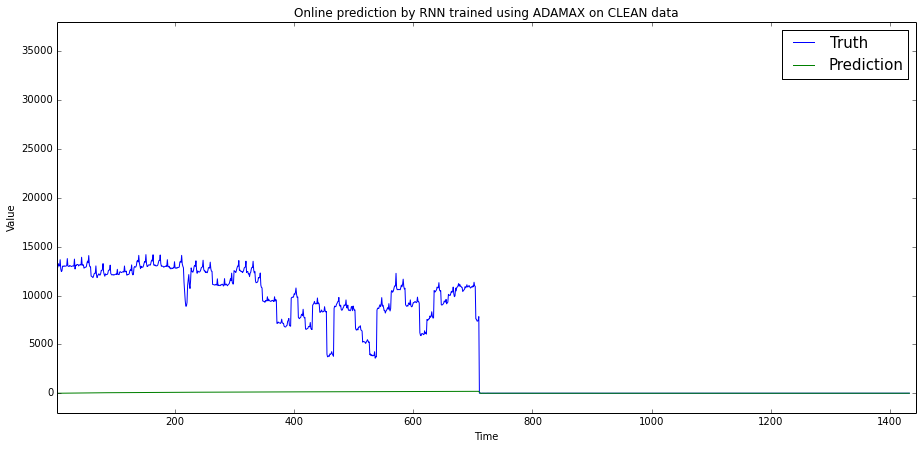

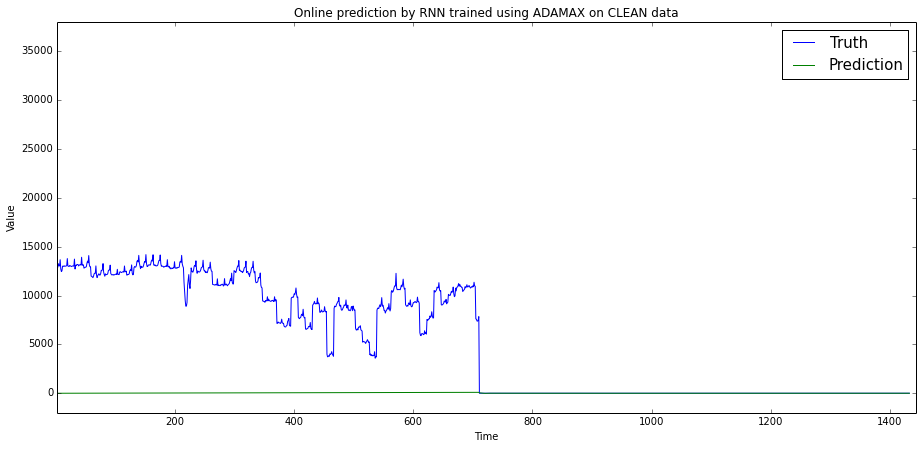

In [84]:
# block 7: real-time train RNN on CLEAN data 
# by different optimzers and plot the prediction results

dtax, dtay = format_timeseries_rnn(  clean_tdf['value'])
loss_func = "mean_squared_error"
allzero_ts_flag = [0]*len(dtax[0])

for optzer in opt_list:
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, optzer, loss_func,allzero_ts_flag)
    test_result_plot(tst_x, tst_y, tst_pred_y ,opt_namelist[i],"CLEAN data")
    
    

In [16]:
# block 8
def prediction_para_plot( tst_y, pred_y_lr, method_name, para_name,para_list,noisyOrClean):
    
    fig = plt.figure()
    figure_size= ( 15.4,7)
    fig.set_size_inches( figure_size )
    
    plt.title('Online prediction by RNN trained using '+ method_name + ' on '+ noisyOrClean)
    plt.ylabel('Value')
    plt.xlabel('Time')

    plt.plot(tst_y, label='Truth')

    print ('Numerical errors on '+ method_name + ':' )
    
    for i in range(len(para_list)):
        plt.plot(pred_y_lr[i], label= para_name + str( para_list[i] ) )
    
        cnt= len(tst_y)
        nmse = sqrt(sum([(tst_y[j]- pred_y_lr[i][j])*(tst_y[j]-  pred_y_lr[i][j] ) for j in range(cnt)])*1.0/cnt)
        print 'Normalzied MSE on '+ para_name + str( para_list[i])+':', nmse
    
    plt.legend( loc='upper right',fontsize=15 )

    axes = plt.gca()
    axes.set_xlim([1, len(tst_y)+10])
    axes.set_ylim([-2000,38000])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
column_labels = list('ABCD')
row_labels = list('WXYZ')
data = np.random.rand(4,4)
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(data.shape[1])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)
plt.show()

Numerical errors on SGD:
Normalzied MSE on Learning rate 0.0001: 1490.56588104
Normalzied MSE on Learning rate 0.001: 1105.65201916
Normalzied MSE on Learning rate 0.01: 56949.5014645
Numerical errors on SGD-Nestorov:
Normalzied MSE on Learning rate 0.0001: 1399.1338951
Normalzied MSE on Learning rate 0.001: 1095.06128285
Normalzied MSE on Learning rate 0.01: 34785.1377222
Numerical errors on RMSprop:
Normalzied MSE on Learning rate 0.0001: 6202.54731752
Normalzied MSE on Learning rate 0.001: 6176.69477948
Normalzied MSE on Learning rate 0.01: 5819.21537844
Normalzied MSE on Learning rate 0.1: 4271.30765666
Normalzied MSE on Learning rate 1: 1165.30061508
Normalzied MSE on Learning rate 10: 4638.25163906
Numerical errors on Ada:
Normalzied MSE on Learning rate 0.0001: 6197.68185409
Normalzied MSE on Learning rate 0.001: 6145.33748949
Normalzied MSE on Learning rate 0.01: 6081.60452468
Normalzied MSE on Learning rate 0.1: 5486.52121547
Normalzied MSE on Learning rate 1: 5663.99435731
No

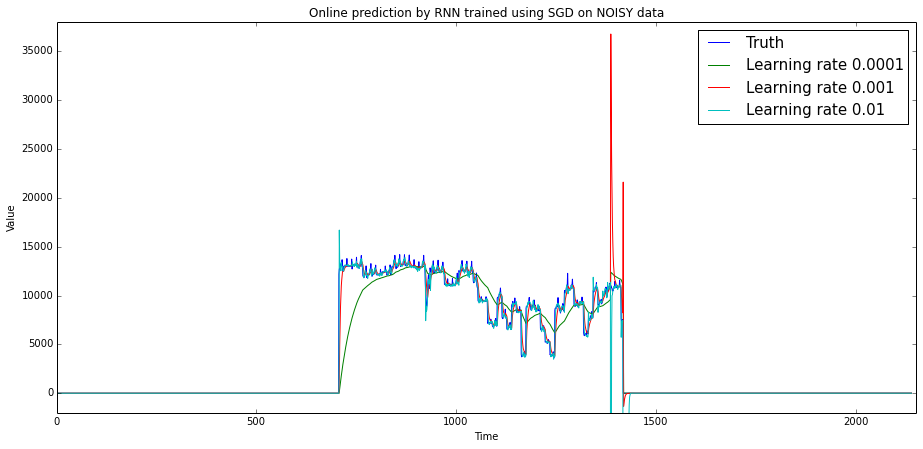

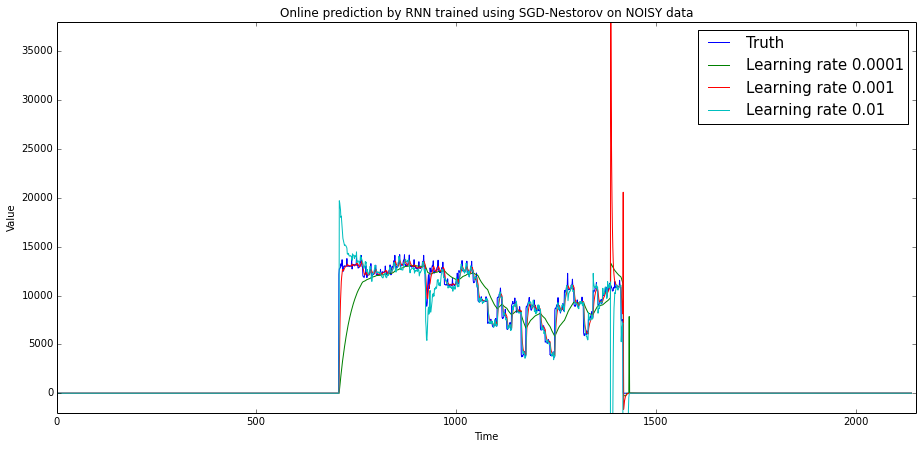

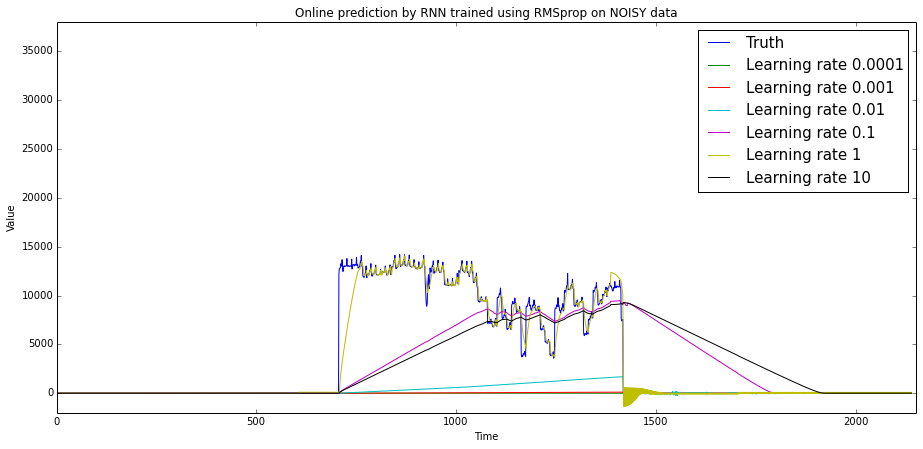

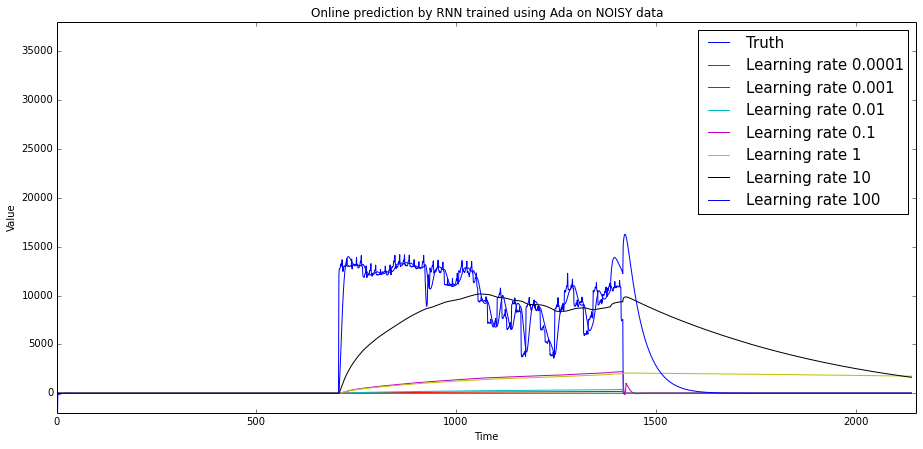

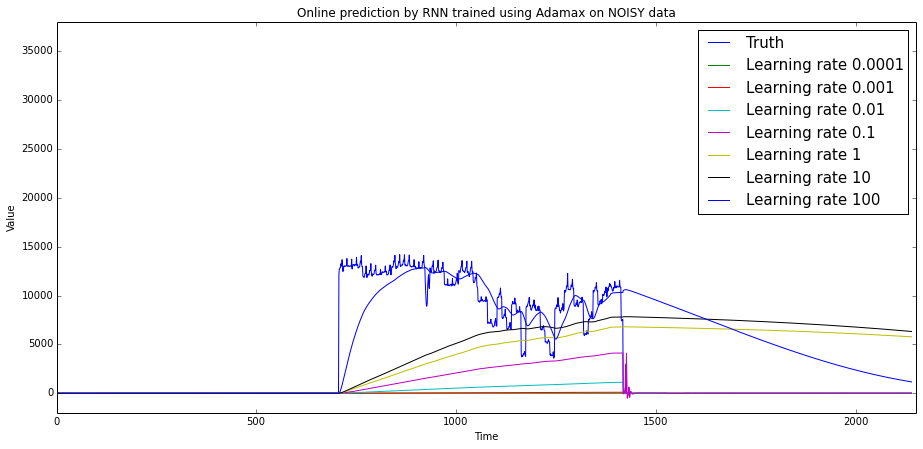

In [15]:
# block 9: train RNN by objective function MEAN_SQUARED_ERROR

dtax, dtay = format_timeseries_rnn( tdf['value'] )
loss_func = "mean_squared_error"

lr_vals=[0.0001,0.001, 0.01 ]
pred_y_lr=[]
for tmp_lr in lr_vals:
    sgd = SGD(lr= tmp_lr, momentum=0.05, decay=0.0, nesterov=False)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, sgd, loss_func,ts_flag,0.1)
    pred_y_lr.append(tst_pred_y)
# prediction_learningRate_plot( tst_y, pred_y_lr, 'SGD' )
prediction_para_plot( tst_y, pred_y_lr,'SGD' , "Learning rate ", lr_vals  )



lr_vals=[0.0001,0.001, 0.01 ]
pred_y_lr=[]
for tmp_lr in lr_vals:
    sgd = SGD(lr= tmp_lr, momentum=0.05, decay=0.0, nesterov=True)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, sgd, loss_func,ts_flag, 0.1)
    pred_y_lr.append(tst_pred_y)
# prediction_learningRate_plot( tst_y, pred_y_lr, 'SGD-Nestorov' )
prediction_para_plot( tst_y, pred_y_lr,'SGD-Nestorov' , "Learning rate ", lr_vals  )



lr_vals=[0.0001,0.001, 0.01, 0.1, 1,10 ]
pred_y_lr=[]
for tmp_lr in lr_vals:
    rms = RMSprop(lr= tmp_lr, rho=0.9, epsilon=1e-06)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, rms, loss_func,ts_flag, 0.0001)
    pred_y_lr.append(tst_pred_y)
# prediction_learningRate_plot( tst_y, pred_y_lr, 'RMSprop' )
prediction_para_plot( tst_y, pred_y_lr,'RMSprop', "Learning rate ", lr_vals  )



#Keras says: it is recommended to leave the parameters of this optimizer 
# at their default values for the two optimizers below

# lr_vals=[0.0001,0.001, 0.01,0.1, 1, 10 ]
# pred_y_lr=[]
# for tmp_lr in lr_vals:
#     adagrad = Adagrad(lr=0.01, epsilon=1e-06)
#     tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, adagrad, loss_func,ts_flag)
#     pred_y_lr.append(tst_pred_y)
# prediction_learningRate_plot( tst_y, pred_y_lr, 'Adagrad' )

# lr_vals=[0.0001,0.001, 0.01 , 0.1, 1,10 ]
# pred_y_lr=[]
# for tmp_lr in lr_vals:
#     adadelta = Adadelta(lr=1.0,rho=0.95,epsilon=1e-06)
#     tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, adadelta, loss_func,ts_flag)
#     pred_y_lr.append(tst_pred_y)
# prediction_learningRate_plot( tst_y, pred_y_lr, 'Adadelta' )


lr_vals=[0.0001,0.001, 0.01 ,0.1, 1,10,100 ]
pred_y_lr=[]
for tmp_lr in lr_vals:
    adam =  Adam(lr= tmp_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, adam, loss_func,ts_flag, 0.001)
    pred_y_lr.append(tst_pred_y)
# prediction_learningRate_plot( tst_y, pred_y_lr, 'Adam' )
prediction_para_plot( tst_y, pred_y_lr,'Ada', "Learning rate ", lr_vals  )


lr_vals=[0.0001,0.001, 0.01 ,0.1, 1,10,100 ]
pred_y_lr=[]
for tmp_lr in lr_vals:
    adamax = Adamax( lr= tmp_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, adamax, loss_func,ts_flag,0.1)
    pred_y_lr.append(tst_pred_y)
prediction_para_plot( tst_y, pred_y_lr,'Adamax', "Learning rate ", lr_vals  )




Numerical errors on SGD:
Normalzied MSE on learning rate 0.0001: 6203.72472469
Normalzied MSE on learning rate 0.001: 6178.32282975
Normalzied MSE on learning rate 0.01: 5883.62298746
Numerical errors on RMSprop:
Normalzied MSE on learning rate 0.0001: 6203.6437036
Normalzied MSE on learning rate 0.001: 6180.0261508
Normalzied MSE on learning rate 0.01: 6018.69481866
Normalzied MSE on learning rate 0.1: 6170.12446775
Normalzied MSE on learning rate 1: 3785.46738312
Normalzied MSE on learning rate 10: 4765.24844636
Numerical errors on Adam:
Normalzied MSE on learning rate 0.0001: 6181.22824117
Normalzied MSE on learning rate 0.001: 6176.47773153
Normalzied MSE on learning rate 0.01: 6179.87433023
Normalzied MSE on learning rate 0.1: 6177.25012187
Normalzied MSE on learning rate 1: 6181.98016077
Normalzied MSE on learning rate 10: 6172.5718523
Numerical errors on Adamax:
Normalzied MSE on learning rate 0.0001: 6180.55336626
Normalzied MSE on learning rate 0.001: 6180.47513231
Normalzied 

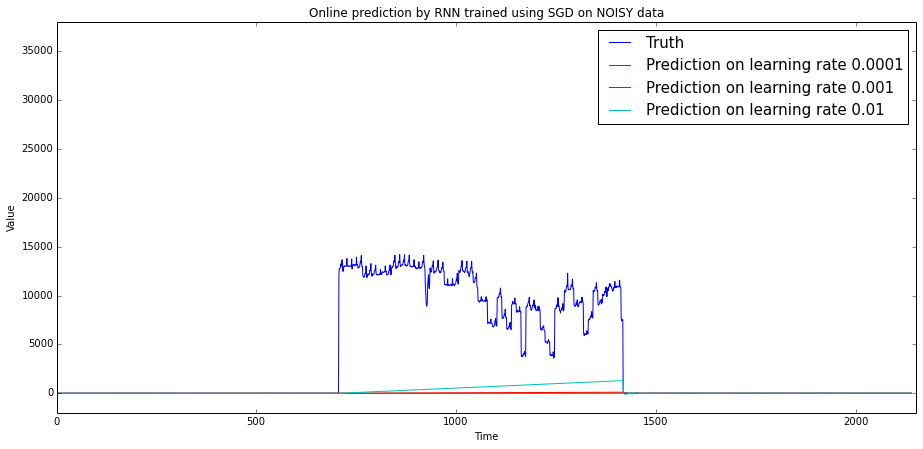

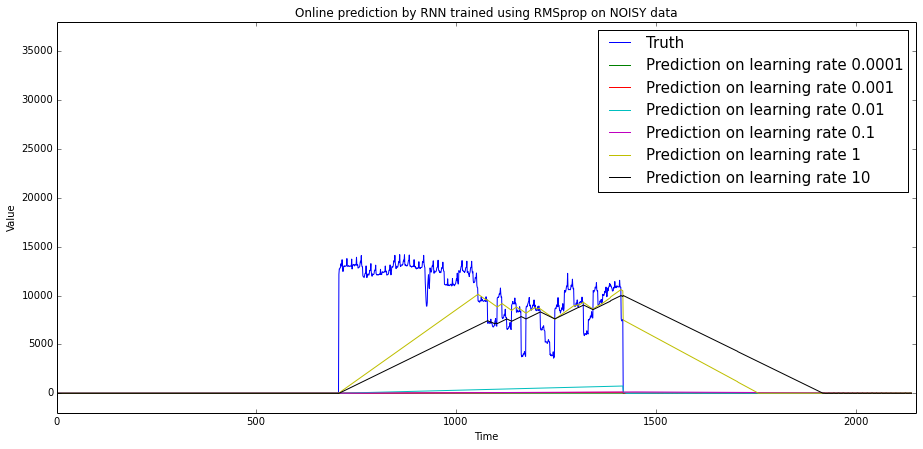

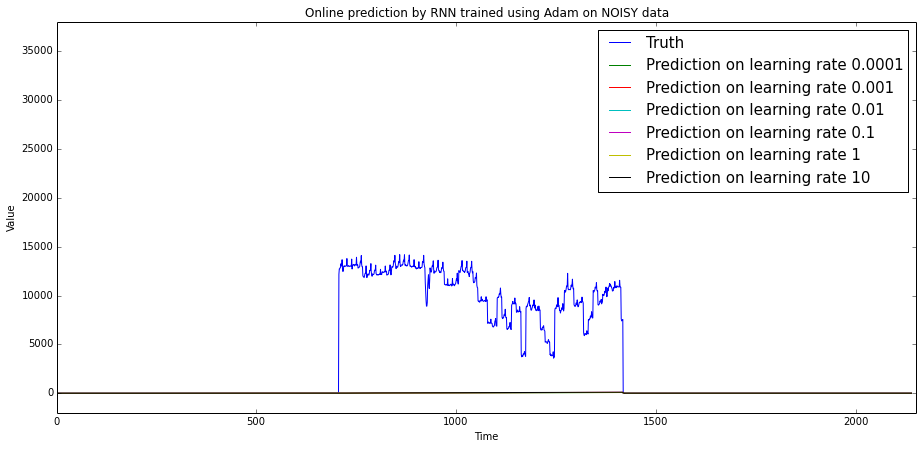

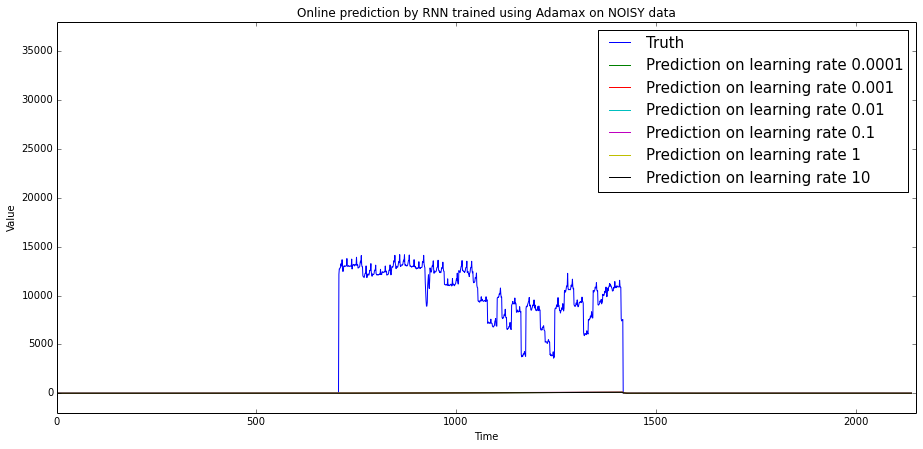

In [112]:
# block 10: train RNN using objective function MEAN_ABSOLUTE_ERROR

dtax, dtay = format_timeseries_rnn( tdf['value'] )
loss_func = "mean_absolute_error"

lr_vals=[0.0001,0.001, 0.01 ]
pred_y_lr=[]
for tmp_lr in lr_vals:
    sgd = SGD(lr= tmp_lr, momentum=0.05, decay=0.0, nesterov=True)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, sgd, loss_func,ts_flag)
    pred_y_lr.append(tst_pred_y)
prediction_learningRate_plot( tst_y, pred_y_lr, 'SGD' )


lr_vals=[0.0001,0.001, 0.01, 0.1, 1,10 ]
pred_y_lr=[]
for tmp_lr in lr_vals:
    rms = RMSprop(lr= tmp_lr, rho=0.9, epsilon=1e-06)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, rms, loss_func,ts_flag)
    pred_y_lr.append(tst_pred_y)
prediction_learningRate_plot( tst_y, pred_y_lr, 'RMSprop' )


#Keras says: it is recommended to leave the parameters of this optimizer 
# at their default values for the two optimizers below

# lr_vals=[0.0001,0.001, 0.01,0.1, 1, 10 ]
# pred_y_lr=[]
# for tmp_lr in lr_vals:
#     adagrad = Adagrad(lr=0.01, epsilon=1e-06)
#     tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, adagrad, loss_func,ts_flag)
#     pred_y_lr.append(tst_pred_y)
# prediction_learningRate_plot( tst_y, pred_y_lr, 'Adagrad' )

# lr_vals=[0.0001,0.001, 0.01 , 0.1, 1,10 ]
# pred_y_lr=[]
# for tmp_lr in lr_vals:
#     adadelta = Adadelta(lr=1.0,rho=0.95,epsilon=1e-06)
#     tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, adadelta, loss_func,ts_flag)
#     pred_y_lr.append(tst_pred_y)
# prediction_learningRate_plot( tst_y, pred_y_lr, 'Adadelta' )


lr_vals=[0.0001,0.001, 0.01 ,0.1, 1,10 ]
pred_y_lr=[]
for tmp_lr in lr_vals:
    adam =  Adam(lr= lr_val, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, adam, loss_func,ts_flag)
    pred_y_lr.append(tst_pred_y)
prediction_learningRate_plot( tst_y, pred_y_lr, 'Adam' )


lr_vals=[0.0001,0.001, 0.01 ,0.1, 1,10 ]
pred_y_lr=[]
for tmp_lr in lr_vals:
    adamax = Adamax(lr= lr_val, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, adamax, loss_func,ts_flag)
    pred_y_lr.append(tst_pred_y)
prediction_learningRate_plot( tst_y, pred_y_lr, 'Adamax' )
    


In [11]:
# block 11: train RNN under different regularization parameters

dtax, dtay = format_timeseries_rnn( tdf['value'] )
loss_func = "mean_squared_error"

res=[]

# Numerical errors on SGD:
# Normalzied MSE on learning rate 0.0001: 1456.61527475
# Normalzied MSE on learning rate 0.001: 1113.75949696
# Normalzied MSE on learning rate 0.01: 7149.09569761
# Numerical errors on RMSprop:
# Normalzied MSE on learning rate 0.0001: 6202.00966882
# Normalzied MSE on learning rate 0.001: 6180.13466764
# Normalzied MSE on learning rate 0.01: 5907.74801984
# Normalzied MSE on learning rate 0.1: 6142.40782181
# Normalzied MSE on learning rate 1: 2037.14537196
# Normalzied MSE on learning rate 10: 4638.25163999
# Numerical errors on Adam:
# Normalzied MSE on learning rate 0.0001: 6176.07928009
# Normalzied MSE on learning rate 0.001: 6173.49752375
# Normalzied MSE on learning rate 0.01: 6172.89995794
# Normalzied MSE on learning rate 0.1: 6167.62692063
# Normalzied MSE on learning rate 1: 6177.17675095
# Normalzied MSE on learning rate 10: 6169.10159163
# Numerical errors on Adamax:
# Normalzied MSE on learning rate 0.0001: 6181.2072312
# Normalzied MSE on learning rate 0.001: 6177.62932219
# Normalzied MSE on learning rate 0.01: 6182.41717582
# Normalzied MSE on learning rate 0.1: 6183.68513158
# Normalzied MSE on learning rate 1: 6178.6078663
# Normalzied MSE on learning rate 10: 6180.0857888

regu_vals=[0.0001,0.001, 0.01, 0.1, 1 ]
pred_y_lr=[]
for tmp in regu_vals:
    sgd = SGD(lr= 0.001, momentum=0.05, decay=0.0, nesterov=True)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, sgd, loss_func,ts_flag, tmp)
    pred_y_lr.append(tst_pred_y)
res.append(pred_y_lr)


regu_vals=[0.0001,0.001, 0.01, 0.1, 1 ]
pred_y_lr=[]
for tmp in regu_vals:
    rms = RMSprop(lr= 1, rho=0.9, epsilon=1e-06)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, rms, loss_func,ts_flag, tmp)
    pred_y_lr.append(tst_pred_y)
res.append(pred_y_lr)


regu_vals=[0.0001,0.001, 0.01, 0.1, 1 ]
pred_y_lr=[]
for tmp in regu_vals:
    adagrad = Adagrad(lr=0.01, epsilon=1e-06)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, adagrad, loss_func,ts_flag, tmp)
    pred_y_lr.append(tst_pred_y)
res.append(pred_y_lr)

regu_vals=[0.0001,0.001, 0.01, 0.1, 1 ]
pred_y_lr=[]
for tmp in regu_vals:
    adadelta = Adadelta(lr=1.0,rho=0.95,epsilon=1e-06)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, adadelta, loss_func,ts_flag, tmp)
    pred_y_lr.append(tst_pred_y)
res.append(pred_y_lr)



regu_vals=[0.0001,0.001, 0.01, 0.1, 1 ]
pred_y_lr=[]
for tmp in regu_vals:
    adam =  Adam(lr= 0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, adam, loss_func,ts_flag, tmp)
    pred_y_lr.append(tst_pred_y)
res.append(pred_y_lr)


regu_vals=[0.0001,0.001, 0.01, 0.1, 1 ]
pred_y_lr=[]
for tmp in regu_vals:
    adamax = Adamax(lr= 1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, adamax, loss_func,ts_flag, tmp)
    pred_y_lr.append(tst_pred_y)
res.append(pred_y_lr)
    


Numerical errors on SGD with Momentum:
Normalzied MSE on Regularizer Parameter0.0001: 1094.99438821
Normalzied MSE on Regularizer Parameter0.001: 1124.40740149
Normalzied MSE on Regularizer Parameter0.01: 1123.74090231
Normalzied MSE on Regularizer Parameter0.1: 1100.58774011
Normalzied MSE on Regularizer Parameter1: 1286.4227855
Numerical errors on RMSprop:
Normalzied MSE on Regularizer Parameter0.0001: 1161.12268267
Normalzied MSE on Regularizer Parameter0.001: 2077.6368646
Normalzied MSE on Regularizer Parameter0.01: 1979.37680578
Normalzied MSE on Regularizer Parameter0.1: 2388.08941318
Normalzied MSE on Regularizer Parameter1: 2226.7136178
Numerical errors on ADAGRAD:
Normalzied MSE on Regularizer Parameter0.0001: 6174.59487347
Normalzied MSE on Regularizer Parameter0.001: 6176.35137276
Normalzied MSE on Regularizer Parameter0.01: 6174.71978813
Normalzied MSE on Regularizer Parameter0.1: 6176.79179574
Normalzied MSE on Regularizer Parameter1: 6172.83832487
Numerical errors on ADAD

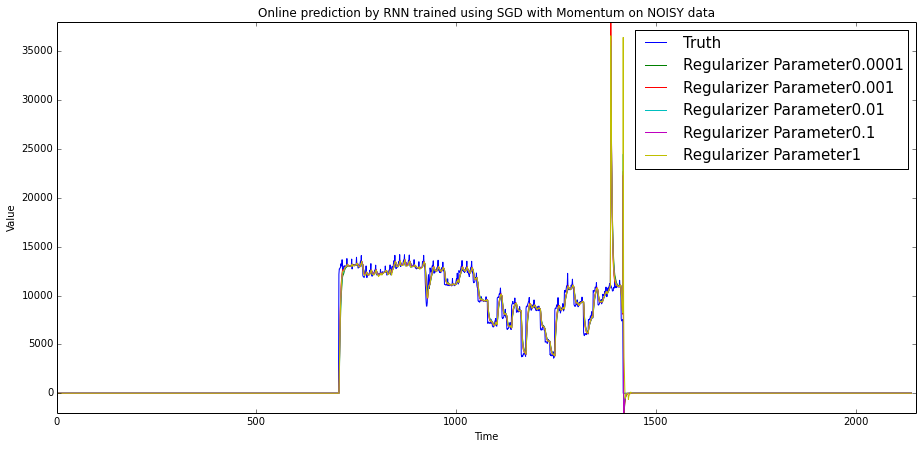

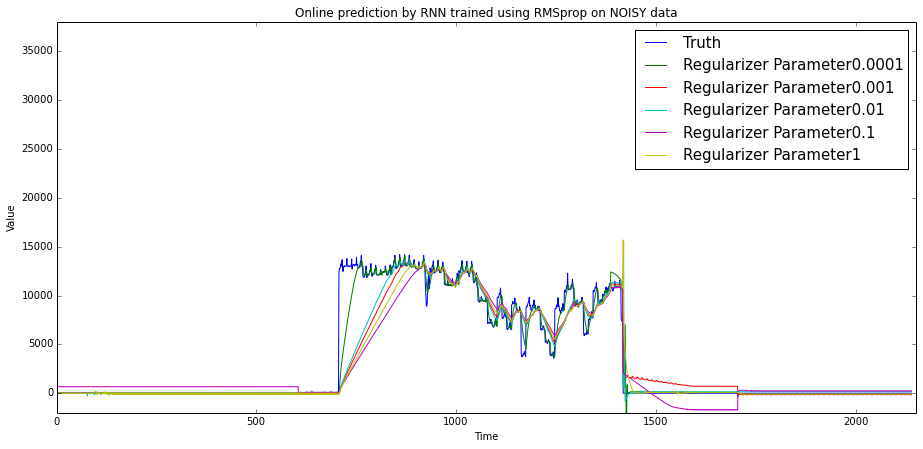

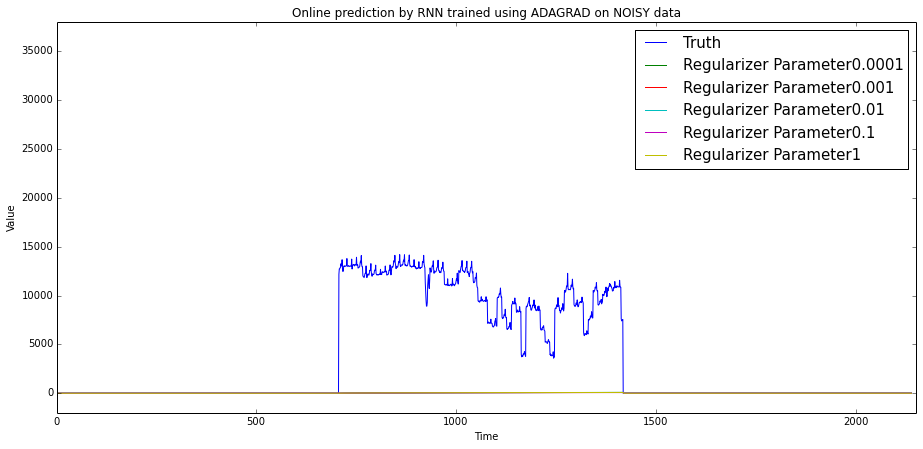

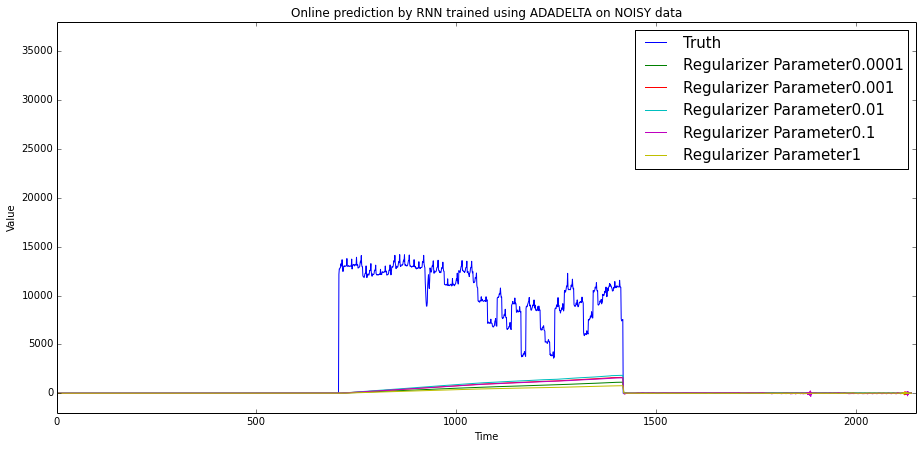

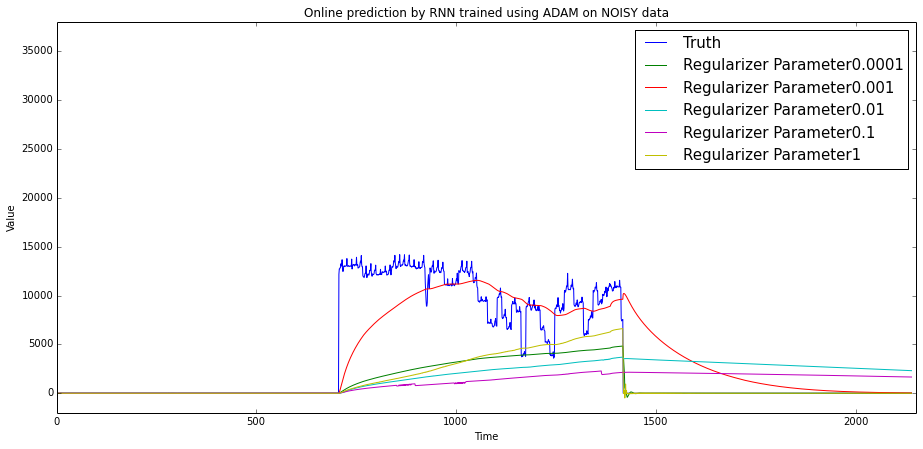

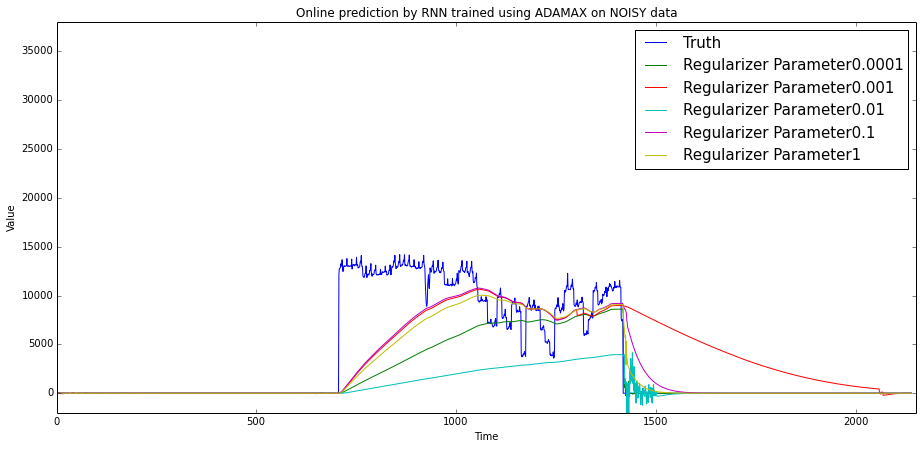

In [17]:
# block 12: prediction result of RNN under different regularization parameter

# opt_namelist=[ "SGD with Momentum","RMSprop","ADAGRAD","ADADELTA","ADAM","ADAMAX" ]
for i in range(len(opt_namelist)):
    pred_y_lr =  res[i]
    prediction_para_plot( tst_y, pred_y_lr, opt_namelist[i], "Regularizer Parameter", regu_vals  )


In [ ]:
# synthetic data

seg_num=5
seg_len_min= 1000
seg_len_max= 4000

mean_min=1
mean_max= 100000
var_min = 1
var_max=100

num_multi_ts=1

figure_size= ( 13.4,7)

def generate_one_ts():
    
    tmpts=[]
    tcnt=0
    tmp_cp_list=[]
    for i in range(seg_num):
        seg_len = int(np.random.uniform([seg_len_min, seg_len_max, 1])[1])
        seg_mean = np.random.uniform([mean_min, mean_max, 1])[1]
        seg_var = seg_mean*0.01
#         np.random.uniform([var_min, var_max, 1])[1]
        
        if i ==0:
            seg_mean = np.random.uniform([1, 10, 1])[1]
            seg_var = seg_mean*0.01
        
        
        if i > 0:
            
        
        
        
        print "segment",i,":",seg_len, seg_mean, tcnt+seg_len
        tmp= np.random.normal( seg_mean, seg_var, seg_len )
        tmp_cp_list.append( tcnt )
        tcnt= tcnt + seg_len   
        [tmpts.append(i) for i in tmp]
    
    return tmpts, tmp_cp_list
    

# single time series 
sts, sts_cps= generate_one_ts()
print "lenght of time series:", len(sts)

fig = plt.figure()
fig.set_size_inches( figure_size )
plt.plot(sts)
plt.title('Singel Time Series')
plt.ylabel('Values')
plt.xlabel('Time (seconds)')


# multi time series
tmp_mts=[]
tmp_mts_cps=[]
tmp_len=[]

fig = plt.figure()
fig.set_size_inches( figure_size )
plt.title('Multi-variate Time Series')
plt.ylabel('Values')
plt.xlabel('Time (seconds)')


for i in range(num_multi_ts):
    tmp_ts, tmp_cp_list= generate_one_ts()
    print "lenght of time series:", len(tmp_ts)
    tmp_len.append(len(tmp_ts))
    tmp_mts.append(tmp_ts)
    tmp_mts_cps.append(tmp_cp_list)
    
#  organize the format of multi-time series for feeding into RNN
mts_len = min(tmp_len)
tmp_mts = [ tmp_mts[i][:mts_len]    for i in range(num_multi_ts)  ]
[   plt.plot(tmp_mts[i]) for i in range(num_multi_ts)  ]


def extract_multiTS_tuple(idx):
    tmplist=[]
    for i in range(num_multi_ts):
        tmplist.append( tmp_mts[i][idx] )
    return tmplist

mul_ts= [ extract_multiTS_tuple(i) for i in range(mts_len) ]

# print len( mul_ts), len(mul_ts[0])


# ---------
if num_multi_ts >1:
    ts= mul_ts
else:
    ts= sts

print len(ts)

In [ ]:
#  real-time RNN training

# continusly feed the data into RNN to update the model
# 
from keras.models import Sequential 
from keras.layers.core import Dense, Activation, TimeDistributedDense 
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop

# parameters
timesteps =1 
in_out_neurons = 1
trn_size= dtax.shape[1]-1
trnx = dtax 
trny = dtay 


testx=[]
testy=[]
testyh=[]

print trnx.shape, trny.shape

rl_model = Sequential()
rl_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
                  batch_input_shape = (1,timesteps, in_out_neurons ) ))
rl_model.add(TimeDistributedDense(output_dim= in_out_neurons ) )
rl_model.add(Activation("linear")) 

rl_model.compile(loss="mean_squared_error", optimizer= rms )
#                  "r11460msprop")

for i in range(trn_size): 
    cur_trnx= trnx[:,i:i+1,:] 
    cur_trny= trny[:,i:i+1,:]
    
#     print 'data instance:', i, 'of size:', cur_trnx.shape, cur_trny.shape

    rl_model.train_on_batch(cur_trnx,cur_trny) 

    if i%50 ==0:
        vali_testx=  trnx[:, i+1:i+2,:]
        pred_test = rl_model.predict_on_batch( vali_testx )[0][0][0]
        print "at time step:",i,":", pred_test, "--v.s.--",trnx[:, i+2:i+3,:][0][0]
        
        testx.append( vali_testx[0][0] )
        testy.append( trnx[:, i+2:i+3,:][0][0])
        testyh.append( pred_test   )

    if i == trn_size-3:
        vali_testx=  trnx[:, i+1:i+2,:]
        pred_test = rl_model.predict_on_batch( vali_testx )[0][0][0]
        print "at time step:",i,":", pred_test, "--v.s.--", trnx[:, i+2:i+3,:][0][0]
        
        testx.append( vali_testx[0][0] )
        testy.append( trnx[:, i+2:i+3,:][0][0])
        testyh.append( pred_test   )
    
#     rl_model.fit(cur_trnx, cur_trny, batch_size=1, nb_epoch=10)
#     validation_split=0.05)

#     predicted = model.predict(X_test)
#     rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))
#     model.predict( X_test[0:10] )

    
#     and maybe plot it
# pd.DataFrame(predicted).to_csv("predicted.csv")
# pd.DataFrame(y_test).to_csv("test_data.csv")

In [ ]:
# models for individual segments
seg_num=4
seg_len_min= 1000
seg_len_max= 2500

mean_min=1
mean_max= 100000
var_min = 1
var_max=100

# RNN parameters
timesteps =1 
in_out_neurons = 1

# figure_size= ( 13.4,7)

tmpts=[]
tmp_cp_list=[]
for i in range(seg_num):
    
    seg_len = int(np.random.uniform([seg_len_min, seg_len_max, 1])[1])
    seg_mean = np.random.uniform([mean_min, mean_max, 1])[1]
    seg_var = seg_mean * 0.1
        
    if i ==0 :
        seg_mean = np.random.uniform([1, 10, 1])[1]
        seg_var = seg_mean * 0.1
        
    print "----- segment--------",i,":",seg_len, seg_mean, seg_len
    tmp= np.random.normal( seg_mean, seg_var, seg_len )
        
    ts_df= pd.DataFrame(tmp)
        
    tmptrnx =[]
    tmptrny =[]
    tmpx,tmpy,tmpy1 = extract_load_data( ts_df, 0, seg_len-1)
    tmptrnx.append(tmpx)
    tmptrny.append(tmpy)
        
    # qualified format for rnn
    dtax = np.array( tmptrnx )
    dtay = np.array( tmptrny )

    print dtax.shape, dtay.shape
        
        
    trn_size= dtax.shape[1]-2
    trnx = dtax 
    trny = dtay 
        
    testx=[]
    testy=[]
    testyh=[]
        
    rl_model = Sequential()
    rl_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
                  batch_input_shape = (1,timesteps, in_out_neurons ), W_regularizer=l2(1) ))
    rl_model.add(Dropout(0.25))

    rl_model.add(TimeDistributedDense(output_dim= in_out_neurons ) )

    rl_model.add(Activation("linear")) 



    rl_model.compile(loss="mean_squared_error",\
                     optimizer= sgd  )
        
    for i in range(trn_size):
        cur_trnx= trnx[:,i:i+1,:] 
        cur_trny= trny[:,i:i+1,:]
            
        rl_model.train_on_batch(cur_trnx,cur_trny) 
            
        if i%10 ==0:
            vali_testx=  trnx[:, i+1:i+2,:]
            pred_test = rl_model.predict_on_batch( vali_testx )[0][0][0]
            print "at time step:",i,":", pred_test, "--v.s.--",trnx[:, i+2:i+3,:][0][0]
        
            testx.append( vali_testx[0][0] )
            testy.append( trnx[:, i+2:i+3,:][0][0])
            testyh.append( pred_test   )
            
        if i == trn_size-3:
            vali_testx=  trnx[:, i+1:i+2,:]
            pred_test = rl_model.predict_on_batch( vali_testx )[0][0][0]
            print "at time step:",i,":", pred_test, "--v.s.--", trnx[:, i+2:i+3,:][0][0]
        
            testx.append( vali_testx[0][0] )
            testy.append( trnx[:, i+2:i+3,:][0][0])
            testyh.append( pred_test   )
    
    

In [8]:
#  real-time rnn training on  yahoo data
from keras.models import Sequential 
from keras.layers.core import Dense, Activation, TimeDistributedDense 
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop

# parameters
timesteps =1 
in_out_neurons = 1
trn_size= dtax.shape[1]-1

is_cleanTrain= 0

trnx = dtax 
trny = dtay 

testx=[]
testy=[]
testyh=[]

print trnx.shape, trny.shape

rl_model = Sequential()
rl_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
                  batch_input_shape = (1,timesteps, in_out_neurons ) ))
rl_model.add(TimeDistributedDense(output_dim= in_out_neurons ) )
rl_model.add(Activation("linear")) 

rl_model.compile(loss="mean_squared_error", optimizer= sgd )
#                  "rmsprop")

for i in range(trn_size): 
    
    if is_cleanTrain==1 and (ts_flag[i]==1 or ts_flag[i+1]==1):
        continue
    
    cur_trnx= trnx[:,i:i+1,:] 
    cur_trny= trny[:,i+1:i+2,:]
    
#     print 'data instance:', i, 'of size:', cur_trnx.shape, cur_trny.shape

    rl_model.train_on_batch(cur_trnx,cur_trny) 
    
    if ts_flag[i]==1:
        print '!!!! outlier happens', cur_trnx, cur_trny

    if i%2 ==0 and ts_flag[i+2]!=1 and ts_flag[i+1]!=1 :
        
        vali_testx=  trnx[:, i+1:i+2,:]
        pred_test = rl_model.predict_on_batch( vali_testx )[0][0][0]
#         print "at time step:",i,":", pred_test, "--v.s.--",trnx[:, i+2:i+3,:][0][0]
        
        testx.append( vali_testx[0][0] )
        testy.append( trnx[:, i+2:i+3,:][0][0])
        testyh.append( pred_test   )

#     if i == trn_size-3:
#         vali_testx=  trnx[:, i+1:i+2,:]
#         pred_test = rl_model.predict_on_batch( vali_testx )[0][0][0]
#         print "at time step:",i,":", pred_test, "--v.s.--", trnx[:, i+2:i+3,:][0][0]
        
#         testx.append( vali_testx[0][0] )
#         testy.append( trnx[:, i+2:i+3,:][0][0])
#         testyh.append( pred_test   )
    

NameError: name 'dtax' is not defined

In [ ]:
#  yahoo data clean

#  accuracy evaluation: plot

tst_yah_x = testx
tst_yah_y = testy
tst_yah_yh = testyh

fig = plt.figure()
fig.set_size_inches( figure_size )
plt.title('Online prediction')
plt.ylabel('Value')
plt.xlabel('Time (seconds)')

plt.plot(tst_yah_y, label='True')
plt.plot(tst_yah_yh, label='Prediction')
plt.legend( loc='upper left',fontsize=15 )

# axes = plt.gca()
# axes.set_xlim([1, tdf.shape[0]+10])
# axes.set_ylim([-1000,1000])

#  error calculation

cnt= len(testy)

nmse = sqrt(sum([(testy[i]- testyh[i])*(testy[i]- testyh[i]) for i in range(cnt)])*1.0/cnt)
print 'Normalzied MSE:', nmse


In [ ]:
#  yahoo data clean

#  accuracy evaluation: plot

tst_yah_x = testx
tst_yah_y = testy
tst_yah_yh = testyh

fig = plt.figure()
fig.set_size_inches( figure_size )
plt.title('Online prediction')
plt.ylabel('Value')
plt.xlabel('Time (seconds)')

plt.plot(tst_yah_y[:2000], label='True')
plt.plot(tst_yah_yh[:2000], label='Prediction')
plt.legend( loc='upper left',fontsize=15 )

# axes = plt.gca()
# axes.set_xlim([1, tdf.shape[0]+10])
# axes.set_ylim([-1000,1000])

#  error calculation


fig = plt.figure()
fig.set_size_inches( figure_size )
plt.title('Online prediction')
plt.ylabel('Value')
plt.xlabel('Time (seconds)')

plt.plot(tst_yah_y[2000:3000], label='True')
plt.plot(tst_yah_yh[2000:3000], label='Prediction')
plt.legend( loc='upper left',fontsize=15 )


fig = plt.figure()
fig.set_size_inches( figure_size )
plt.title('Online prediction')
plt.ylabel('Value')
plt.xlabel('Time (seconds)')

plt.plot(tst_yah_y[3000:-1], label='True')
plt.plot(tst_yah_yh[3000:-1], label='Prediction')
plt.legend( loc='upper left',fontsize=15 )


cnt= len(testy)
print cnt
nmse = sqrt(sum([(testy[i]- testyh[i])*(testy[i]- testyh[i]) for i in range(cnt)])*1.0/cnt)
print 'Normalzied MSE:', nmse


In [ ]:
#  yahoo data noisy

#  accuracy evaluation: plot

tst_yah_x = testx
tst_yah_y = testy
tst_yah_yh = testyh

fig = plt.figure()
fig.set_size_inches( figure_size )
plt.title('Online prediction')
plt.ylabel('Value')
plt.xlabel('Time (seconds)')

plt.plot(tst_yah_y[:2000], label='True')
plt.plot(tst_yah_yh[:2000], label='Prediction')
plt.legend( loc='upper left',fontsize=15 )

# axes = plt.gca()
# axes.set_xlim([1, tdf.shape[0]+10])
# axes.set_ylim([-1000,1000])

#  error calculation


fig = plt.figure()
fig.set_size_inches( figure_size )
plt.title('Online prediction')
plt.ylabel('Value')
plt.xlabel('Time (seconds)')

plt.plot(tst_yah_y[2000:3000], label='True')
plt.plot(tst_yah_yh[2000:3000], label='Prediction')
plt.legend( loc='upper left',fontsize=15 )


fig = plt.figure()
fig.set_size_inches( figure_size )
plt.title('Online prediction')
plt.ylabel('Value')
plt.xlabel('Time (seconds)')

plt.plot(tst_yah_y[3000:-1], label='True')
plt.plot(tst_yah_yh[3000:-1], label='Prediction')
plt.legend( loc='upper left',fontsize=15 )


cnt= len(testy)
print cnt
nmse = sqrt(sum([(testy[i]- testyh[i])*(testy[i]- testyh[i]) for i in range(cnt)])*1.0/cnt)
print 'Normalzied MSE:', nmse


Normalzied MSE: 7850.67202095


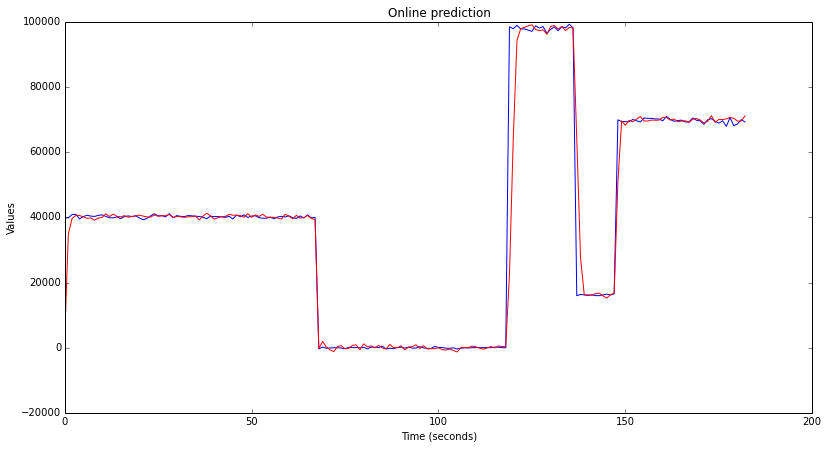

In [121]:
#  uni-variate synthetic time series

#  lr = 7, mean_min=1  mean_max= 100000 
#  accuracy evaluation: plot

tst_ts_x = testx
tst_ts_y = testy
tst_ts_yh = testyh


fig = plt.figure()
fig.set_size_inches( figure_size )
plt.title('Online prediction')
plt.ylabel('Value')
plt.xlabel('Time (seconds)')

plt.plot(tst_ts_y, color = 'blue')
plt.plot(tst_ts_yh, color='red')

#  error calculation

cnt= len(testy)

nmse = sqrt(sum([(testy[i]- testyh[i])*(testy[i]- testyh[i]) for i in range(cnt)])*1.0/cnt)
print 'Normalzied MSE:', nmse


Normalzied MSE: 64.2571743342


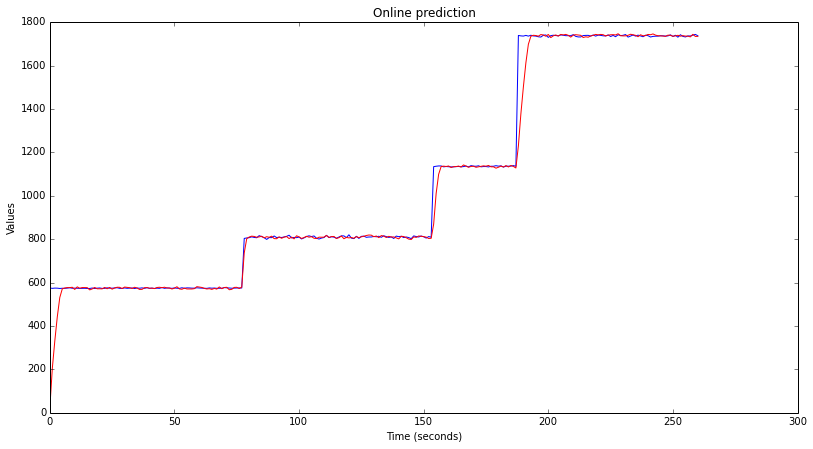

In [77]:
#  uni-variate synthetic time series

#  lr =0.08
#  accuracy evaluation: plot

tst_ts_x = testx
tst_ts_y = testy
tst_ts_yh = testyh


fig = plt.figure()
fig.set_size_inches( figure_size )
plt.title('Online prediction')
plt.ylabel('Value')
plt.xlabel('Time (seconds)')

plt.plot(tst_ts_y, color = 'blue')
plt.plot(tst_ts_yh, color='red')

#  error calculation

cnt= len(testy)

nmse = sqrt(sum([(testy[i]- testyh[i])*(testy[i]- testyh[i]) for i in range(cnt)])*1.0/cnt)
print 'Normalzied MSE:', nmse


Normalzied MSE: 86.7191609263


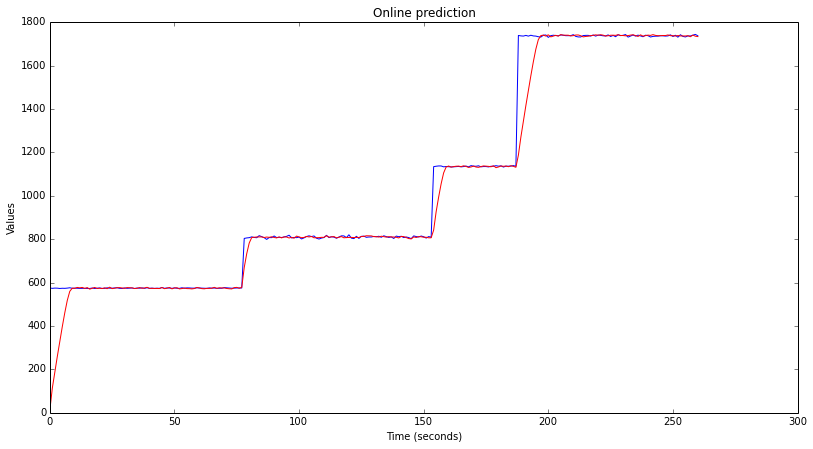

In [75]:
#  uni-variate synthetic time series

#  lr =0.04
#  accuracy evaluation: plot

tst_ts_x = testx
tst_ts_y = testy
tst_ts_yh = testyh


fig = plt.figure()
fig.set_size_inches( figure_size )
plt.title('Online prediction')
plt.ylabel('Value')
plt.xlabel('Time (seconds)')

plt.plot(tst_ts_y, color = 'blue')
plt.plot(tst_ts_yh, color='red')

#  error calculation

cnt= len(testy)

nmse = sqrt(sum([(testy[i]- testyh[i])*(testy[i]- testyh[i]) for i in range(cnt)])*1.0/cnt)
print 'Normalzied MSE:', nmse


Normalzied MSE: 10.6533957326


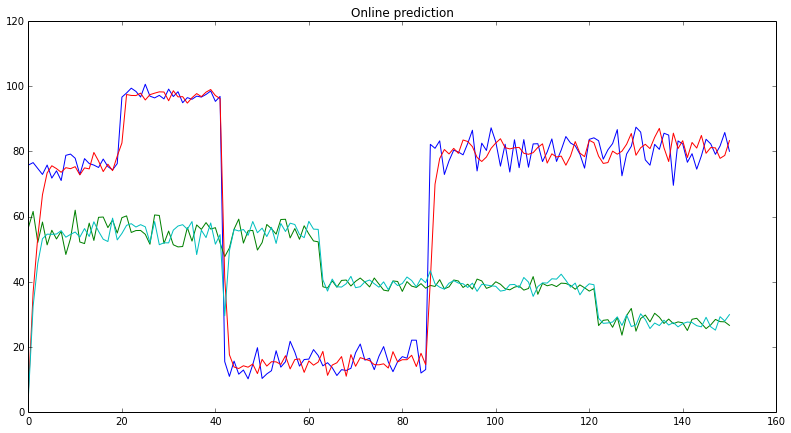

In [57]:
#  multi-variate synthetic time series

#  accuracy evaluation: plot
tst_mts_x = testx
tst_mts_y = testy
tst_mts_yh = testyh

fig = plt.figure()
fig.set_size_inches( figure_size )
plt.title('Online prediction')
plt.ylabel('Value')
plt.xlabel('Time (seconds)')

plt.plot(tst_mts_y)
plt.plot(tst_mts_yh)

#  error calculation
cnt= len(testy)

nmse = sqrt(sum([(testy[i]- testyh[i])*(testy[i]- testyh[i]) for i in range(cnt)])*1.0/cnt)
print 'Normalzied MSE:', nmse


In [ ]:
#   Bayesian change point detection based on real-time learning of rnn

significance_level = 0.05

cur_seg_stPos=0
cur_seg_cnt=0
ini_run_len=100


#  residual statistics
resi_mean=0.0
resi_sqr = 0.0
resi_var=0.0

# parameter about the hazard function
hconst = 0.3
hrange= seg_len_max
hpiece_num=50
hpiece =[]
hpiece_event=[]
hpiece_psum=[]


# detected change-points
detect_cp_list=[]

# data instances for training RNN
xtrain= dtax
ytrain= dtay
total_len=len(xtrain) 
print xtrain.shape, ytrain.shape


# initialize the network structure
in_dim = 1
hidden_neurons = 800
timesteps =1
in_out_neurons = 2


cp_model = Sequential()
cp_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
               batch_input_shape = (1,timesteps,in_out_neurons )   ))
cp_model.add(Dropout(0.25))
cp_model.add(TimeDistributedDense(output_dim=in_out_neurons ) )
cp_model.add(Activation("linear"))
rms = RMSprop(lr=0.04, rho=0.9, epsilon=1e-06)
cp_model.compile(loss="mean_squared_error", optimizer=rms )


# initialize the model
cur_trnx= xtrain[:,0:1,:]
cur_trny= ytrain[:,0:1,:]
cp_model.train_on_batch(cur_trnx,cur_trny) 



# ---------------hazard function component------------
def hazard_bsearch( arr, t):
    
    tmplen=len(arr)
    l= 0
    r= tmplen
    
    while( l< r-1):
        mid= int(l+ (r-l)/2.0)
        tmpval= arr[mid][0]
        
        if tmpval> t:
            r= mid
        else:
            l=mid
    
    if t<= arr[l][0]:
        return l
    elif t>= arr[r][0]:
        return r+1
    else:
        return r
    
def hazard_constant():
    return hconst
    
def hazard_piece_ini():
    tmpinter = hrange*1.0 / hpiece_num
    tmph = 1.0 / hpiece_num
    curh=0.0
    
    for i in range(hpiece_num):
        curh= curh+ tmph
        hpiece.append(  [tmpinter*(i+1), curh ]  )
        
        hpiece_event.append(  [tmpinter*(i+1), 0 ]  )
        hpiece_psum.append(  0  )
            
def hazard_piece_qry( cond_t ):
    tmpidx = hazard_bsearch( hpiece, cond_t)
    return hpiece[tmpidx][1]
    
def hazard_update_event( t):
    tmpidx = hazard_bsearch( hpiece_event, t)
    hpiece_event[tmpidx][1] = hpiece_event[tmpidx][1]+1

def hazard_update_piece():
    
    tmp_psum=[]
    tmp=0.0
    tmpsum=0.0
    for i in range(hpiece_num):
        tmp = tmp+ hpiece_event[i][1]
        tmp_psum.append(tmp)
    
    tmpsum= tmp
    
    for i in range(hpiece_num):
        if (tmpsum- tmp_psum[i]+hpiece_event[i][1])!=0 and hpiece_event[i][1]!=0:
            hpiece[i][1] =  hpiece_event[i][1]*1.0/(tmpsum-tmp_psum[i]+hpiece_event[i][1])
    
def hazard_adjust_piece():
    return 1
    
    

#-------------------run-lenght  joint distribution ---------------------

rlen_dist=[]

def rlen_dist_ini():
    for i in range(seg_len_max):
        rlen_dist.append(0)
    rlen_dist[0]=1

def rlen_update( cur_rlen, pred_prob):
    
    rlen_dist[ cur_rlen ] = rlen_dist[ cur_rlen-1 ]*pred_prob* ( 1.0- hazard_piece_qry( cur_rlen-1 )) 
    
    rlen_dist[ 0 ] = rlen_dist[ cur_rlen-1 ]*pred_prob* ( hazard_piece_qry( cur_rlen-1 )) 

    
def rlen_evidence():
    tmpval=0.0
    for i in range(seg_len_max):
        tmpval =  tmpval + rlen_dist[i]
    return tmpval
    
def rlen_conditional(cur_rlen):
    
    return rlen_dist[cur_rlen]/rlen_evidence()

def rlen_renormal():
    return 1
   
# normalize the run-lenght distribution    
    
# --------------------------------------------------------------------
    
hazard_piece_ini()
# print hpiece

    
# the main process
for i in range(1,400):
    
    
#   current data instance for training the model
    cur_trnx= xtrain[:,i:i+1,:]
    cur_trny= ytrain[:,i:i+1,:]
    
#       use so-far training model to predict first 
    vali_testx=  xtrain[:, i:i+1,:]
    curPred= cp_model.predict_on_batch( vali_testx )
    
#       residual of the current data instance w.r.t. the predicted value
    tmpresi =  curPred[0][0][0][0] - ytrain[0, i, 0]
    
    
    if i - cur_seg_stPos <=  ini_run_len:
        
        resi_mean= ( resi_mean * cur_seg_cnt*1.0 + tmpresi)/(cur_seg_cnt+1)
        cur_seg_cnt = cur_seg_cnt+1
        resi_sqr = resi_sqr + tmpresi*tmpresi
        resi_var= resi_sqr/cur_seg_cnt - resi_mean* resi_mean 
        
#         if i - cur_seg_stPos>= ini_run_len-10:
#             resi_mean= ( resi_mean * cur_seg_cnt*1.0 + tmpresi)/(cur_seg_cnt+1)
#             cur_seg_cnt = cur_seg_cnt+1
#             resi_sqr = resi_sqr + tmpresi*tmpresi
#             resi_var= resi_sqr/cur_seg_cnt - resi_mean* resi_mean         
        
        
#       update the model for the current segment
        cp_model.train_on_batch(cur_trnx, cur_trny)
    
        print "initial phase:", tmpresi, resi_mean,resi_var
#         curPred[0][0][0][0],ytrain[0, i, 0]

        continue
        
#       z-value
    resi_mean=0.0
    tmp_zval = (tmpresi -  resi_mean)*1.0 / 1.0*sqrt(resi_var/cur_seg_cnt)
    tmp_pro =  st.norm.cdf( tmp_zval)
        
    print "at time step:",cur_seg_cnt,":", curPred[0][0][0][0], ytrain[0, i, 0], resi_mean,resi_var,tmp_pro
#     curPred, ytrain[:, i:i+1,:], tmp_zval   
    
    
#---------------test component------------------------


    resi_mean= ( resi_mean * cur_seg_cnt*1.0 + tmpresi)/(cur_seg_cnt+1)
    cur_seg_cnt = cur_seg_cnt+1
    resi_sqr = resi_sqr + tmpresi*tmpresi
    resi_var= resi_sqr/cur_seg_cnt - resi_mean* resi_mean             
        
    cp_model.train_on_batch(cur_trnx, cur_trny) 
    
    
#------------------------------------------------------    
        
#     if tmp_pro <= significance_level or tmp_pro >= 1.0-significance_level:
# #       initialize a new segment 
#         cur_seg_stPos =i
#         cur_seg_cnt = 1
            
#         resi_mean= x[i]
#         resi_sqr = x[i]*x[i]*1.0
#         resi_var =  0.0
            
#         detect_cp_list.append(i)

#         reset weights
#         cp_model.reset_states()

#         cp_model.clear_previous(reset_weights=True)
        
# #       initialize a model for the new segment
#         cp_model.train_on_batch(cur_trnx,cur_trny) 
    
# #       update the hazard component
#         hazard_update_event(  i - cur_seg_stPos )
            
#     else:
        
# #      stay in the current segment and update the residual statistics 
#         resi_mean= ( resi_mean * cur_seg_cnt*1.0 + tmpresi)/cur_seg_cnt
#         cur_seg_cnt = cur_seg_cnt+1
#         resi_sqr = resi_sqr + tmpresi*tmpresi
#         resi_var= resi_sqr/cur_seg_cnt - resi_mean* resi_mean             
        
# #       update the model for the current segment
#         cp_model.train_on_batch(cur_trnx, cur_trny) 
    
            
            


In [ ]:
# parameter selection for real-time rnn training on keras
from keras.models import Sequential 
from keras.layers.core import Dense, Activation, TimeDistributedDense 
from keras.layers.recurrent import LSTM

# parameters
timesteps =1 
input_dim=1
in_out_neurons = 1 
hidden_neurons = 10000
trn_size= 2 
# dtax.shape[1]-10
trnx = dtax 
trny = dtay 

print trnx.shape, trny.shape


for num in range(3500,4000,200):
    
    print 'number of hidden neurons:', num

    
    rl_model = Sequential()
    rl_model.add(LSTM( num, return_sequences=True, stateful= True,\
                  batch_input_shape = (1,timesteps,input_dim ) ))
    rl_model.add(TimeDistributedDense(output_dim=1 ) )
    rl_model.add(Activation("linear")) 
    rl_model.compile(loss="mean_squared_error", optimizer="rmsprop")
    
    for i in range(trn_size):
        cur_trnx= trnx[:,i:i+1,:] 
        cur_trny= trny[:,i:i+1,:]
    
        print '     data instance:', i, 'of size:', cur_trnx.shape, cur_trny.shape

        rl_model.train_on_batch(cur_trnx,cur_trny) 

#     if i%50 ==0:
#         vali_testx=  trnx[:, i+1:i+2,:]
#         print "at time step:",i,":", rl_model.predict_on_batch( vali_testx )

#     if i == trn_size-1:
#         vali_testx=  trnx[:, i+1:i+2,:]
#         print "at time step:",i,":", rl_model.predict_on_batch( vali_testx )
    
        rl_model.fit(cur_trnx, cur_trny, batch_size=1, nb_epoch=10)
#     validation_split=0.05)

#     predicted = model.predict(X_test)
#     rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))
#     model.predict( X_test[0:10] )

    
#     and maybe plot it
# pd.DataFrame(predicted).to_csv("predicted.csv")
# pd.DataFrame(y_test).to_csv("test_data.csv")

In [ ]:
# block hazard comopnent test

# parameter about the hazard function
# hconst = 0.3
# hpiece_num=50

# hrange= seg_len_max
# hpiece =[]
# hpiece_event=[]
# hpiece_psum=[]


def hazard_bsearch( arr, t):
    
    tmplen=len(arr)
    l= 0
    r= tmplen
    
    while( l< r-1):
        mid= int(l+ (r-l)/2.0)
        tmpval= arr[mid][0]
        
        if tmpval> t:
            r= mid
        else:
            l=mid
    
    if t<= arr[l][0]:
        return l
    elif t>= arr[r][0]:
        return r+1
    else:
        return r
    
def hazard_constant():
    return hconst
    
def hazard_piece_ini():
    tmpinter = hrange*1.0 / hpiece_num
    tmph = 1.0 / hpiece_num
    curh=0.0
    
    for i in range(hpiece_num):
        curh= curh+ tmph
        hpiece.append(  [tmpinter*(i+1), curh ]  )
        
        hpiece_event.append(  [tmpinter*(i+1), 0 ]  )
        hpiece_psum.append(  0  )
            
def hazard_piece_qry( cond_t ):
    tmpidx = hazard_bsearch( hpiece, cond_t)
    return hpiece[tmpidx][1]
    
def hazard_update_event( t):
    tmpidx = hazard_bsearch( hpiece_event, t)
    hpiece_event[tmpidx][1] = hpiece_event[tmpidx][1]+1

def hazard_update_piece():

#   mechanism for keepting default values
    tmp_psum=[]
    tmp=0.0
    tmpsum=0.0
    for i in range(hpiece_num):
        tmp = tmp+ hpiece_event[i][1]
        tmp_psum.append(tmp)
    
    tmpsum= tmp
    
    for i in range(hpiece_num):
        hpiece[i][1] =  hpiece_event[i][1]*1.0/(tmpsum- tmp_psum[i]+hpiece_event[i][1])
    
    

    
# ...................test.........................

# print hazard_constant()
# hazard_piece_ini()
# print hpiece
# hazard_piece_qry(201)

# hazard_update_event(4130)    
print hpiece_event
    
hazard_update_piece()

print hpiece

In [ ]:
#  build online-rnn learning framework


#  state-full lstm 
#  https://github.com/fchollet/keras/blob/master/examples/stateful_lstm.py

# Q&A:
#  stateful lstm
#  variational
#  time steps: maximum time lag?
#  if residula is not white gaussian 

#  septerate modeling on conditions
